# PeakIdentify - Example and Functionality

***

This notebook walks you through the usage and functionality of the updated peakidentify function. First, the functionality will be shown by just calling the wrapper function, but subsequent examples will explore the sub-functions and explain their usage. 

This function was created by the Raman Noodles Dev Team, and we hope you find it to your liking. Feel free to leave issues for suggested improvments. 

# 2 THINGS TO CONSIDER
#### NEED TO IMPROVE Visualization and Documentation
#### NEED TO IMPROVE Score sort function and optimize using regression

### Example 0.A: Data Input

First, we'll generate the dataset that we will use to explore this functionality. This data will be downloaded from _____

. In order to generate an "unknown spectrum" that we will be attempting to fit, ____________, and feed that in as our unknown dataset. For further explanation of the dataprep or spectrafit packages, refer to the Jupyter notebooks which present examples of their usage, also found in this repo.

In [1]:
import os
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import lineid_plot
from ramandecompy import spectrafit
from ramandecompy import peakidentify
from ramandecompy import dataprep
from ramandecompy import datavis


We will use a pair of known spectra from our calibration list and put it in hdf5 format with the dataprep module. See dataprep example for more details. The functions new_hdf5 and add_calibration should only be called once or else an File Already exists error will be raised

In [2]:
# when you add a new hdf5 file you use this function below
dataprep.new_hdf5('peakidentify_calibration_file')


In [3]:
dataprep.view_hdf5('peakidentify_calibration_file.hdf5') #already have this

**** peakidentify_calibration_file.hdf5 ****


In [4]:
dataprep.add_calibration('peakidentify_calibration_file.hdf5',
                          '../ramandecompy/tests/test_files/Hydrogen_Baseline_Calibration.xlsx',
                          label='Hydrogen')

Data from ../ramandecompy/tests/test_files/Hydrogen_Baseline_Calibration.xlsx fit with compound pseudo-Voigt model. Results saved to peakidentify_calibration_file.hdf5.


In [5]:
dataprep.add_calibration('peakidentify_calibration_file.hdf5',
                          '../ramandecompy/tests/test_files/CarbonMonoxide_Baseline_Calibration.xlsx',
                          label='CarbonMonoxide')

Data from ../ramandecompy/tests/test_files/CarbonMonoxide_Baseline_Calibration.xlsx fit with compound pseudo-Voigt model. Results saved to peakidentify_calibration_file.hdf5.


In [6]:
dataprep.add_calibration('peakidentify_calibration_file.hdf5','../ramandecompy/tests/test_files/CO2_100wt%.csv',label='CO2')

Data from ../ramandecompy/tests/test_files/CO2_100wt%.csv fit with compound pseudo-Voigt model. Results saved to peakidentify_calibration_file.hdf5.


In [7]:
dataprep.add_calibration('peakidentify_calibration_file.hdf5','../ramandecompy/tests/test_files/water.xlsx',label='H2O')

Data from ../ramandecompy/tests/test_files/water.xlsx fit with compound pseudo-Voigt model. Results saved to peakidentify_calibration_file.hdf5.


In [8]:
dataprep.add_calibration('peakidentify_calibration_file.hdf5','../ramandecompy/tests/test_files/sapphire.xlsx',label='sapphire')

Data from ../ramandecompy/tests/test_files/sapphire.xlsx fit with compound pseudo-Voigt model. Results saved to peakidentify_calibration_file.hdf5.


In [9]:
#checking the components in the file -- these are the pure component spectra only for calibration use
test_example = h5py.File('peakidentify_calibration_file.hdf5', 'r+')
list(test_example.keys())

['CO2', 'CarbonMonoxide', 'H2O', 'Hydrogen', 'sapphire']

In [10]:
#checking the values of the files
list(test_example.values())

[<HDF5 group "/CO2" (5 members)>,
 <HDF5 group "/CarbonMonoxide" (4 members)>,
 <HDF5 group "/H2O" (5 members)>,
 <HDF5 group "/Hydrogen" (7 members)>,
 <HDF5 group "/sapphire" (7 members)>]

In [11]:
type(test_example) #checking the type of the files

h5py._hl.files.File

(<Figure size 1080x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d0e38ab5c0>)

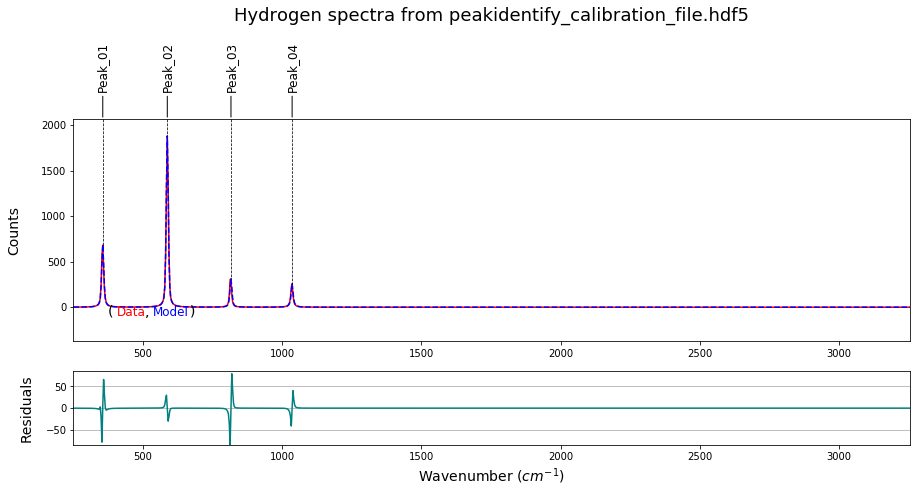

In [12]:
# plotted known spectra with detected peaks
datavis.plot_fit('peakidentify_calibration_file.hdf5', 'Hydrogen') #plotting the hydrogen after going through with dataprep

(<Figure size 1080x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d0e4064860>)

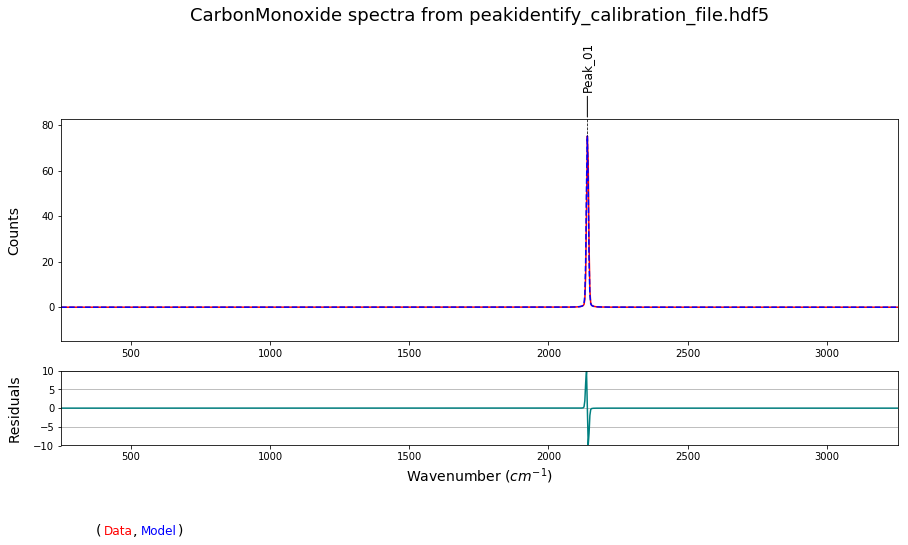

In [13]:
datavis.plot_fit('peakidentify_calibration_file.hdf5', 'CarbonMonoxide')

(<Figure size 1080x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d0e3bf5518>)

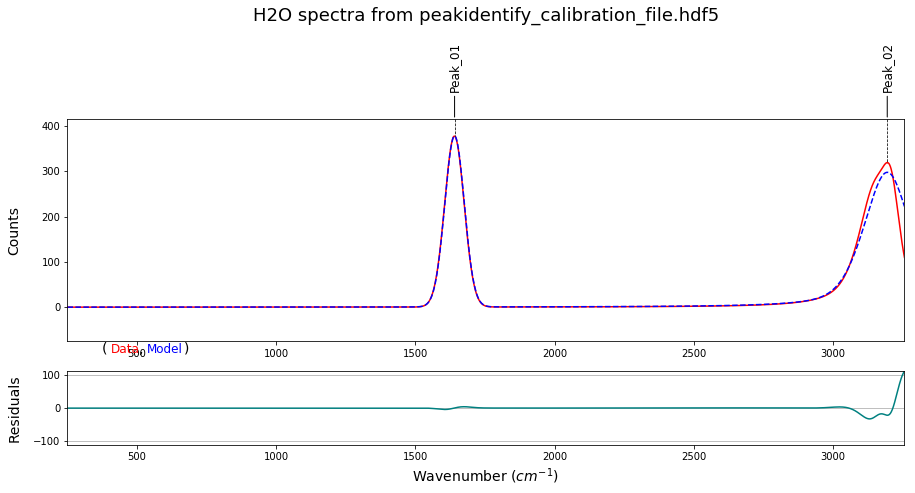

In [14]:
datavis.plot_fit('peakidentify_calibration_file.hdf5', 'H2O')

(<Figure size 1080x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d0e3cb56d8>)

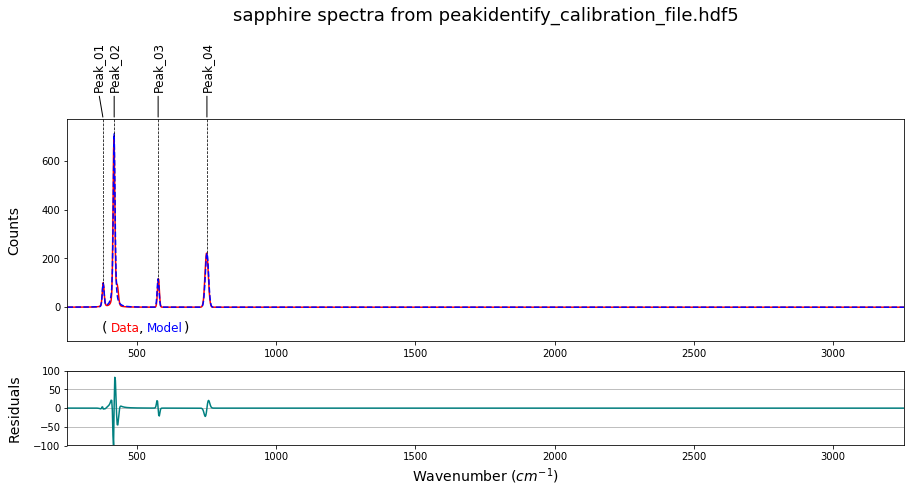

In [15]:
datavis.plot_fit('peakidentify_calibration_file.hdf5', 'sapphire')

(<Figure size 1080x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d0e37ba470>)

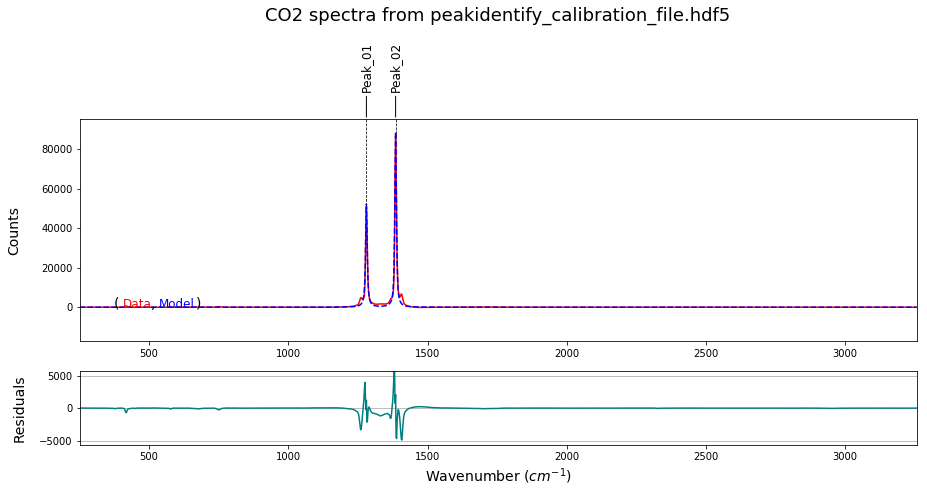

In [16]:
datavis.plot_fit('peakidentify_calibration_file.hdf5', 'CO2')

In [17]:
dataprep.new_hdf5('peakidentify_experiment_file')
dataprep.add_experiment('peakidentify_experiment_file.hdf5', '../ramandecompy/tests/test_files/FA_3.6wt%_300C_25s.csv') 

Data from ../ramandecompy/tests/test_files/FA_3.6wt%_300C_25s.csv fit with compound pseudo-Voigt model. Results saved to peakidentify_experiment_file.hdf5.


In [18]:
dataprep.view_hdf5('peakidentify_experiment_file.hdf5')

**** peakidentify_experiment_file.hdf5 ****
300C
|    25s
|    |    Peak_01
|    |    Peak_02
|    |    Peak_03
|    |    Peak_04
|    |    Peak_05
|    |    Peak_06
|    |    Peak_07
|    |    Peak_08
|    |    Peak_09
|    |    Peak_10
|    |    Peak_11
|    |    Peak_12
|    |    Peak_13
|    |    Peak_14
|    |    Peak_15
|    |    Peak_16
|    |    counts
|    |    residuals
|    |    wavenumber


(<Figure size 1080x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d0e4694588>)

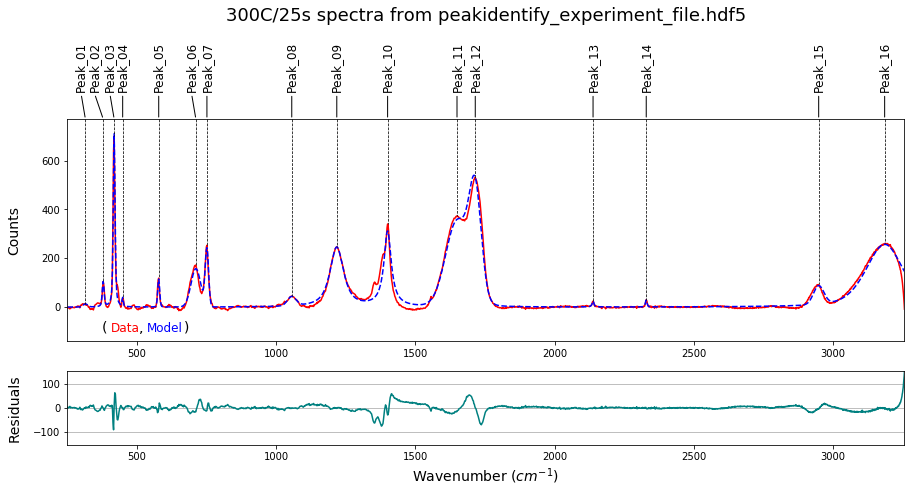

In [19]:
datavis.plot_fit('peakidentify_experiment_file.hdf5', '300C/25s')

In [20]:
dataprep.new_hdf5('peakidentify_label_test')


In [21]:
dataprep.add_experiment('peakidentify_label_test.hdf5', '../ramandecompy/tests/test_files/FA_3.6wt%_300C_25s.csv')

Data from ../ramandecompy/tests/test_files/FA_3.6wt%_300C_25s.csv fit with compound pseudo-Voigt model. Results saved to peakidentify_label_test.hdf5.


In [22]:
dataprep.view_hdf5('peakidentify_calibration_file.hdf5')

**** peakidentify_calibration_file.hdf5 ****
CO2
|    Peak_01
|    Peak_02
|    counts
|    residuals
|    wavenumber
CarbonMonoxide
|    Peak_01
|    counts
|    residuals
|    wavenumber
H2O
|    Peak_01
|    Peak_02
|    counts
|    residuals
|    wavenumber
Hydrogen
|    Peak_01
|    Peak_02
|    Peak_03
|    Peak_04
|    counts
|    residuals
|    wavenumber
sapphire
|    Peak_01
|    Peak_02
|    Peak_03
|    Peak_04
|    counts
|    residuals
|    wavenumber


In [23]:
dataprep.view_hdf5('peakidentify_label_test.hdf5')

**** peakidentify_label_test.hdf5 ****
300C
|    25s
|    |    Peak_01
|    |    Peak_02
|    |    Peak_03
|    |    Peak_04
|    |    Peak_05
|    |    Peak_06
|    |    Peak_07
|    |    Peak_08
|    |    Peak_09
|    |    Peak_10
|    |    Peak_11
|    |    Peak_12
|    |    Peak_13
|    |    Peak_14
|    |    Peak_15
|    |    Peak_16
|    |    counts
|    |    residuals
|    |    wavenumber


(<Figure size 1080x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d0e4d0def0>)

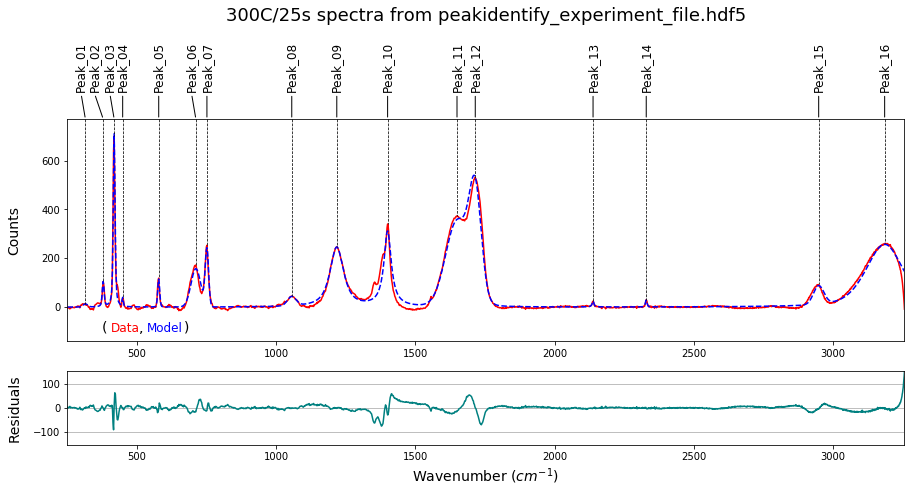

In [24]:
datavis.plot_fit('peakidentify_experiment_file.hdf5', '300C/25s')

### Example 0.B: Test Driven Development - test functions (will be deleted for final version)
06032019 tests have correct directories and nosetests passes


In [25]:
dataprep.new_hdf5('peakidentify_experiment_test')

In [26]:
dataprep.add_experiment('peakidentify_experiment_test.hdf5', '../ramandecompy/tests/test_files/FA_3.6wt%_300C_25s.csv')

Data from ../ramandecompy/tests/test_files/FA_3.6wt%_300C_25s.csv fit with compound pseudo-Voigt model. Results saved to peakidentify_experiment_test.hdf5.


In [27]:
dataprep.new_hdf5('peakidentify_calibration_test')
dataprep.add_calibration('peakidentify_calibration_test.hdf5',
                          '../ramandecompy/tests/test_files/Hydrogen_Baseline_Calibration.xlsx',
                          label='Hydrogen')
dataprep.add_calibration('peakidentify_calibration_test.hdf5',
                          '../ramandecompy/tests/test_files/CarbonMonoxide_Baseline_Calibration.xlsx',
                          label='CarbonMonoxide')
dataprep.add_calibration('peakidentify_calibration_test.hdf5','../ramandecompy/tests/test_files/CO2_100wt%.csv',label='CO2')
dataprep.add_calibration('peakidentify_calibration_test.hdf5','../ramandecompy/tests/test_files/water.xlsx',label='H2O')
dataprep.add_calibration('peakidentify_calibration_test.hdf5','../ramandecompy/tests/test_files/sapphire.xlsx',label='sapphire')

Data from ../ramandecompy/tests/test_files/Hydrogen_Baseline_Calibration.xlsx fit with compound pseudo-Voigt model. Results saved to peakidentify_calibration_test.hdf5.
Data from ../ramandecompy/tests/test_files/CarbonMonoxide_Baseline_Calibration.xlsx fit with compound pseudo-Voigt model. Results saved to peakidentify_calibration_test.hdf5.
Data from ../ramandecompy/tests/test_files/CO2_100wt%.csv fit with compound pseudo-Voigt model. Results saved to peakidentify_calibration_test.hdf5.
Data from ../ramandecompy/tests/test_files/water.xlsx fit with compound pseudo-Voigt model. Results saved to peakidentify_calibration_test.hdf5.
Data from ../ramandecompy/tests/test_files/sapphire.xlsx fit with compound pseudo-Voigt model. Results saved to peakidentify_calibration_test.hdf5.


In [28]:
dataprep.new_hdf5('peakidentify_add_label_test')
dataprep.add_experiment('peakidentify_add_label_test.hdf5',
                        '../ramandecompy/tests/test_files/FA_3.6wt%_300C_25s.csv')

Data from ../ramandecompy/tests/test_files/FA_3.6wt%_300C_25s.csv fit with compound pseudo-Voigt model. Results saved to peakidentify_add_label_test.hdf5.


In [29]:
"""
Module used to unit test the functionality and outputs of the peakidentify.py module
"""
# IMPORTING MODULES
import os
import h5py
import numpy as np
from ramandecompy import peakidentify
from ramandecompy import dataprep



def test_peak_assignment():
    """This function tests the operation of the peak_assignment
    function in peakidentify.py"""
    #First, generate a testing dataset.
#     dataprep.new_hdf5('peakidentify_calibration_test')
#     dataprep.add_calibration('peakidentify_calibration_test.hdf5',
#                              '../tests/test_files/Hydrogen_Baseline_Calibration.xlsx',
#                              label='Hydrogen')
#     dataprep.add_calibration('peakidentify_calibration_test.hdf5',
#                              '../tests/test_files/CarbonMonoxide_Baseline_Calibration.xlsx',
#                              label='CarbonMonoxide')
#     dataprep.add_calibration('peakidentify_calibration_test.hdf5',
#                              '../tests/test_files/CO2_100wt%.csv',
#                              label='CO2')
#     dataprep.add_calibration('peakidentify_calibration_test.hdf5','../tests/test_files/water.xlsx',label='H2O')
#     dataprep.add_calibration('peakidentify_calibration_test.hdf5','../tests/test_files/sapphire.xlsx',label='sapphire')
#     dataprep.new_hdf5('peakidentify_experiment_test')
#     dataprep.add_experiment('peakidentify_experiment_test.hdf5',
#                             '../tests/test_files/FA_3.6wt%_300C_25s.csv')
    hdf5_calfilename = 'peakidentify_calibration_test.hdf5'
    hdf5_expfilename = 'peakidentify_experiment_test.hdf5'
    temp = 300
    time = 25
    calhdf5 = h5py.File(hdf5_calfilename, 'r+')
    exphdf5 = h5py.File(hdf5_expfilename, 'r+')
    unknown_x = list(exphdf5['{}C/{}s/wavenumber'.format(temp, time)])
    unknown_y = list(exphdf5['{}C/{}s/counts'.format(temp, time)])
    unknown_x = np.asarray(unknown_x)
    unknown_y = np.asarray(unknown_y)
    precision = 50
    #Various try statements to make sure that bad inputs are handled correctly.

    try:
        peakidentify.peak_assignment(hdf5_expfilename,
                                     temp, time, hdf5_calfilename,
                                     precision, False, False)

    except TypeError:
        print("An invalid known_compound_list was passed to the function, "
              "and it was handled well with a TypeError.")

    try:
        peakidentify.peak_assignment(hdf5_expfilename,
                                     temp, time, hdf5_calfilename,
                                     'precision', False, False)

    except TypeError:
        print("An invalid precision value was passed to the function, and "
              "it was handled well with a TypeError.")

    try:
        peakidentify.peak_assignment(hdf5_expfilename,
                                     temp, time, hdf5_calfilename,
                                     precision, 'False', False)

    except TypeError:
        print("An invalid export label value was passed to the function, and it "
              "was handled well with a TypeError.")

    try:
        peakidentify.peak_assignment(hdf5_expfilename,
                                     temp, time, hdf5_calfilename,
                                     precision, False, 'False')

    except TypeError:
        print("An invalid plot value was passed to the function, and it "
              "was handled well with a TypeError.")

    exphdf5.close()
    calhdf5.close()
#     os.remove('peakidentify_calibration_test.hdf5')
#     os.remove('peakidentify_experiment_test.hdf5')

def test_compare_unknown_to_known():
    """This function tests the operation of the compare_unknown_to_known
    function in peakidentify.py"""
    #First, generate a testing dataset.
#     dataprep.new_hdf5('peakidentify_calibration_test')
#     dataprep.add_calibration('peakidentify_calibration_test.hdf5',
#                              '../tests/test_files/Hydrogen_Baseline_Calibration.xlsx',
#                              label='Hydrogen')
#     dataprep.add_calibration('peakidentify_calibration_test.hdf5',
#                              '../tests/test_files/CarbonMonoxide_Baseline_Calibration.xlsx',
#                              label='CarbonMonoxide')
#     dataprep.add_calibration('peakidentify_calibration_test.hdf5',
#                              '../tests/test_files/CO2_100wt%.csv',
#                              label='CO2')
#     dataprep.add_calibration('peakidentify_calibration_test.hdf5','../tests/test_files/water.xlsx',label='H2O')
#     dataprep.add_calibration('peakidentify_calibration_test.hdf5','../tests/test_files/sapphire.xlsx',label='sapphire')
#     dataprep.new_hdf5('peakidentify_experiment_test')
#     dataprep.add_experiment('peakidentify_experiment_test.hdf5',
#                             '../tests/test_files/FA_3.6wt%_300C_25s.csv')
    hdf5_calfilename = 'peakidentify_calibration_test.hdf5'
    hdf5_expfilename = 'peakidentify_experiment_test.hdf5'
    temp = 300
    time = 25
    calhdf5 = h5py.File(hdf5_calfilename, 'r+')
    exphdf5 = h5py.File(hdf5_expfilename, 'r+')
    unknown_x = list(exphdf5['{}C/{}s/wavenumber'.format(temp, time)])
    unknown_y = list(exphdf5['{}C/{}s/counts'.format(temp, time)])
    unknown_x = np.asarray(unknown_x)
    unknown_y = np.asarray(unknown_y)
    known_compound_list = list(calhdf5.keys())
    precision = 50
    known_peaks = []
    known_peaks_list = []
    unknown_peaks = []
    for i, _ in enumerate(list(exphdf5['{}C/{}s'.format(temp, time)])[:-3]):
        if i < 9:
            unknown_peaks.append(list(exphdf5['{}C/{}s/Peak_0{}'.format(temp,
                                                                        time,
                                                                        i+1)])[0][2])
        else:
            unknown_peaks.append(list(exphdf5['{}C/{}s/Peak_{}'.format(temp,
                                                                       time,
                                                                       i+1)])[0][2])
    for i, _ in enumerate(known_compound_list):
        for _, peak in enumerate(list(calhdf5[known_compound_list[i]])[:-3]):
            known_peaks_list.append(list(calhdf5['{}/{}'.format(known_compound_list[i],
                                                                peak)])[0][2])
        known_peaks.append(known_peaks_list[i])

    try:
        peakidentify.compare_unknown_to_known(1, known_peaks, precision)
    except TypeError:
        print("An invalid unknown_peaks value was passed to the function, "
              "and was handled correctly.")

    try:
        peakidentify.compare_unknown_to_known(unknown_peaks, 'known_peaks', precision)
    except TypeError:
        print("An invalid known_peaks value was passed to the function, "
              "and was handled correctly.")

    try:
        peakidentify.compare_unknown_to_known(unknown_peaks, known_peaks, 'precision')
    except TypeError:
        print("An invalid precision value was passed to the function, and "
              "was handled correctly.")

    #After testing for resilience to unexpected inputs, now ensure
    #outputs are performing correctly

    #First, make sure function is returning the list.
    assert isinstance(peakidentify.compare_unknown_to_known(
        unknown_peaks, known_peaks, precision), np.ndarray), ("""Function
        is not returning list""")

    #Compare one set of peaks to itself. The full association matrix
    #should have all values = 1.
    self_comp = np.mean(peakidentify.compare_unknown_to_known(known_peaks,
                                                              known_peaks,
                                                              precision))
    assert self_comp == 1, ("Peak Assignment Error. Comparison of compound "
                            "against itself should find all peaks.")

    dif_comp = np.mean(peakidentify.compare_unknown_to_known([1, 3, 6],
                                                             [1000, 2000, 5000],
                                                             precision))
    assert dif_comp == 0, ("Peak Assignment Error. Passed values should "
                           "have no matching assignments.")

    exphdf5.close()
    calhdf5.close()
#     os.remove('peakidentify_calibration_test.hdf5')
#     os.remove('peakidentify_experiment_test.hdf5')

def test_peak_position_comparisons():
    """This function tests the operation of the peak_position_comparisons
    function in peakidentify. Said function returns a list of strings that
    contain text assignments of each peak in the unknown spectrum."""

    #First, generate a testing dataset.
#     dataprep.new_hdf5('peakidentify_calibration_test')
#     dataprep.add_calibration('peakidentify_calibration_test.hdf5',
#                              '../tests/test_files/Hydrogen_Baseline_Calibration.xlsx',
#                              label='Hydrogen')
#     dataprep.add_calibration('peakidentify_calibration_test.hdf5',
#                              '../tests/test_files/CarbonMonoxide_Baseline_Calibration.xlsx',
#                              label='CarbonMonoxide')
#     dataprep.add_calibration('peakidentify_calibration_test.hdf5',
#                              '../tests/test_files/CO2_100wt%.csv',
#                              label='CO2')
#     dataprep.add_calibration('peakidentify_calibration_test.hdf5','../tests/test_files/water.xlsx',label='H2O')
#     dataprep.add_calibration('peakidentify_calibration_test.hdf5','../tests/test_files/sapphire.xlsx',label='sapphire')
#     dataprep.new_hdf5('peakidentify_experiment_test')
#     dataprep.add_experiment('peakidentify_experiment_test.hdf5',
#                             '../tests/test_files/FA_3.6wt%_300C_25s.csv')
    hdf5_calfilename = 'peakidentify_calibration_test.hdf5'
    hdf5_expfilename = 'peakidentify_experiment_test.hdf5'
    temp = 300
    time = 25
    calhdf5 = h5py.File(hdf5_calfilename, 'r+')
    exphdf5 = h5py.File(hdf5_expfilename, 'r+')
    unknown_x = list(exphdf5['{}C/{}s/wavenumber'.format(temp, time)])
    unknown_y = list(exphdf5['{}C/{}s/counts'.format(temp, time)])
    unknown_x = np.asarray(unknown_x)
    unknown_y = np.asarray(unknown_y)
    known_compound_list = list(calhdf5.keys())
    precision = 50
    known_peaks = []
    known_peaks_list = []
    association_matrix = []
    unknown_peaks = []
    for i, _ in enumerate(list(exphdf5['{}C/{}s'.format(temp, time)])[:-3]):
        if i < 9:
            unknown_peaks.append(list(exphdf5['{}C/{}s/Peak_0{}'.format(temp,
                                                                        time,
                                                                        i+1)])[0][2])
        else:
            unknown_peaks.append(list(exphdf5['{}C/{}s/Peak_{}'.format(temp,
                                                                       time,
                                                                       i+1)])[0][2])
    known_peaks = []
    known_peaks_list = []
    num_peaks_list = []
    association_matrix = []
    split__index_list = []
    for i, _ in enumerate(known_compound_list):
        num_peaks_list.append(len(list(calhdf5[known_compound_list[i]])[:-3]))
        split__index_list.append(sum(num_peaks_list))
        for j, peak in enumerate(list(calhdf5[known_compound_list[i]])[:-3]):
            # Need to separate known peaks to make a list of two separate lists
            # to perform custom list split using list comprehension + zip()
            # and split_index_list
            known_peaks_list.append(list(calhdf5['{}/{}'.format(known_compound_list[i],
                                                                peak)])[0][2])
            result = [known_peaks_list[i : j] for i, j in zip([0] + split__index_list,
                                                              split__index_list +
                                                              [None])]
        known_peaks.append(result)
        association_matrix.append(peakidentify.compare_unknown_to_known(
            unknown_peaks, known_peaks[i][i], precision))

    #Then, test error handling of bad inputs for the function.
    try:
        peakidentify.peak_position_comparisons(1, known_peaks,
                                               association_matrix,
                                               hdf5_calfilename)

    except TypeError:
        print("An invalid unknown_peaks value was passed to the function, "
              "and was handled correctly.")

    try:
        peakidentify.peak_position_comparisons(unknown_peaks,
                                               'known_peaks',
                                               association_matrix,
                                               hdf5_calfilename)

    except TypeError:
        print("An invalid known_peaks value was passed to the function, "
              "and was handled correctly.")

    try:
        peakidentify.peak_position_comparisons(unknown_peaks,
                                               known_peaks,
                                               'association_matrix',
                                               hdf5_calfilename)

    except TypeError:
        print("An invalid association_matrix value was passed to the function,"
              "and was handled correctly.")

    #Check to make sure the function is returning a list.
    assert isinstance(peakidentify.peak_position_comparisons(
        unknown_peaks, known_peaks,
        association_matrix, hdf5_calfilename), list), """The function is
        not returning a list."""

    #Test a call that says that no peaks have associations
    association_matrix_0 = []

    association_matrix_0.append(peakidentify.compare_unknown_to_known(
        known_peaks[0][0],
        known_peaks[1][0],
        precision))

    zero_output = peakidentify.peak_position_comparisons(known_peaks[0][0],
                                                         [known_peaks[1][0]],
                                                         association_matrix_0,
                                                         hdf5_calfilename)[0]

    assert zero_output[0] == 'CO2', """The function is not properly
    handling unassigned peaks."""

    #Test the function to make sure that it has the right functionality
    association_matrix = []
    #Generate a matrix with all associations equal to 1
    association_matrix.append(peakidentify.compare_unknown_to_known(
        known_peaks[0][0],
        known_peaks[0][0],
        precision))

    #change the middle index to 0
    association_matrix[0][1] = 0
    test_peak_labels = peakidentify.peak_position_comparisons(known_peaks[0][0],
                                                              [known_peaks[0][0]],
                                                              association_matrix,
                                                              hdf5_calfilename)
    print(test_peak_labels[0][0])
    print(test_peak_labels[1][0])

    assert test_peak_labels[0][0] == 'CO2', """The funciton is
    not correctly assigning peaks when association matrix = 1"""
    assert test_peak_labels[1][0] == 'Unassigned', """The function is
    not correctly handling a lack of peak assignments"""

    exphdf5.close()
    calhdf5.close()
#     os.remove('peakidentify_calibration_test.hdf5')
#     os.remove('peakidentify_experiment_test.hdf5')

def test_percentage_of_peaks_found():
    """This function tests the operation of the
    percentage_of_peaks_found function in peakidentify.py"""

    #First, generate a testing dataset.
#     dataprep.new_hdf5('peakidentify_calibration_test')
#     dataprep.add_calibration('peakidentify_calibration_test.hdf5',
#                              '../tests/test_files/Hydrogen_Baseline_Calibration.xlsx',
#                              label='Hydrogen')
#     dataprep.add_calibration('peakidentify_calibration_test.hdf5',
#                              '../tests/test_files/CarbonMonoxide_Baseline_Calibration.xlsx',
#                              label='CarbonMonoxide')
#     dataprep.add_calibration('peakidentify_calibration_test.hdf5',
#                              '../tests/test_files/CO2_100wt%.csv',
#                              label='CO2')
#     dataprep.add_calibration('peakidentify_calibration_test.hdf5','../tests/test_files/water.xlsx',label='H2O')
#     dataprep.add_calibration('peakidentify_calibration_test.hdf5','../tests/test_files/sapphire.xlsx',label='sapphire')
#     dataprep.new_hdf5('peakidentify_experiment_test')
#     dataprep.add_experiment('peakidentify_experiment_test.hdf5',
#                             '../tests/test_files/FA_3.6wt%_300C_25s.csv')
    hdf5_calfilename = 'peakidentify_calibration_test.hdf5'
    hdf5_expfilename = 'peakidentify_experiment_test.hdf5'
    temp = 300
    time = 25
    calhdf5 = h5py.File(hdf5_calfilename, 'r+')
    exphdf5 = h5py.File(hdf5_expfilename, 'r+')
    unknown_x = list(exphdf5['{}C/{}s/wavenumber'.format(temp, time)])
    unknown_y = list(exphdf5['{}C/{}s/counts'.format(temp, time)])
    unknown_x = np.asarray(unknown_x)
    unknown_y = np.asarray(unknown_y)
    known_compound_list = list(calhdf5.keys())
    precision = 50

    unknown_peaks = []
    for i, _ in enumerate(list(exphdf5['{}C/{}s'.format(temp, time)])[:-3]):
        if i < 9:
            unknown_peaks.append(list(exphdf5['{}C/{}s/Peak_0{}'.format(temp,
                                                                        time,
                                                                        i+1)])[0][2])
        else:
            unknown_peaks.append(list(exphdf5['{}C/{}s/Peak_{}'.format(temp,
                                                                       time,
                                                                       i+1)])[0][2])
    known_peaks = []
    known_peaks_list = []
    num_peaks_list = []
    association_matrix = []
    split__index_list = []
    for i, _ in enumerate(known_compound_list):
        num_peaks_list.append(len(list(calhdf5[known_compound_list[i]])[:-3]))
        split__index_list.append(sum(num_peaks_list))
        for j, peak in enumerate(list(calhdf5[known_compound_list[i]])[:-3]):
            # Need to separate known peaks to make a list of two separate lists
            # to perform custom list split using list comprehension + zip()
            # and split_index_list
            known_peaks_list.append(list(calhdf5['{}/{}'.format(known_compound_list[i],
                                                                peak)])[0][2])
            result = [known_peaks_list[i : j] for i, j in zip([0] + split__index_list,
                                                              split__index_list +
                                                              [None])]
        known_peaks.append(result)
        association_matrix.append(peakidentify.compare_unknown_to_known(
            unknown_peaks, known_peaks[i][i], precision))

    #Test for input error handling.

    try:
        peakidentify.percentage_of_peaks_found([[0], [1], [2], [3], [4], [5]],
                                                association_matrix, hdf5_calfilename)
    except TypeError:
        print("""The function correctly handled the error when a list of ints
        was input instead of the known_peaks list""")

    try:
        peakidentify.percentage_of_peaks_found(1, association_matrix,
                                               hdf5_calfilename)

    except TypeError:
        print("""The function correctly handled the error when an int
        was input instead of the known_peaks list""")

    try:
        peakidentify.percentage_of_peaks_found(known_peaks, 1,
                                               known_compound_list,
                                               hdf5_calfilename)

    except TypeError:
        print("""The function correctly handled the error when an int
        was input instead of the association matrix""")


    #Test to make sure function returns a dictionary.
    assert isinstance(peakidentify.percentage_of_peaks_found(
        known_peaks,
        association_matrix,
        hdf5_calfilename), dict), """The function is not
        returning a dictionary."""

#     #Test for function output.
    co2_peaks = []
    key = 'CO2'
    for _, peak in enumerate(list(calhdf5[key])[:-3]):
        co2_peaks.append(list(calhdf5['{}/{}'.format(key, peak)])[0][2])
    print(co2_peaks)
    co2_dict_0 = peakidentify.percentage_of_peaks_found([co2_peaks, [0], [0], [0], [0]],
                                                        [[0, 0], [0], [0],[0], [0]],
                                                        hdf5_calfilename)
    assert co2_dict_0[key] == 0, """The function is not correctly
    calculating percentages when no peaks are found"""

    co2_dict_1 = peakidentify.percentage_of_peaks_found([co2_peaks, [1], [1],[1], [1]],
                                                        [[1, 1], [1], [1],[1], [1]],
                                                        hdf5_calfilename)
    assert co2_dict_1[key] == 100, """The function is not correctly
    calculating percentages when all peaks are found"""

    exphdf5.close()
    calhdf5.close()
#     os.remove('peakidentify_calibration_test.hdf5')
#     os.remove('peakidentify_experiment_test.hdf5')

def test_plotting_peak_assignments():
    """This function tests the operation of the peak_assignment
    function in peakidentify.py"""
    #First, generate a testing dataset.
#     dataprep.new_hdf5('peakidentify_calibration_test')
#     dataprep.add_calibration('peakidentify_calibration_test.hdf5',
#                              '../tests/test_files/Hydrogen_Baseline_Calibration.xlsx',
#                              label='Hydrogen')
#     dataprep.add_calibration('peakidentify_calibration_test.hdf5',
#                              '../tests/test_files/CarbonMonoxide_Baseline_Calibration.xlsx',
#                              label='CarbonMonoxide')
#     dataprep.add_calibration('peakidentify_calibration_test.hdf5',
#                              '../tests/test_files/CO2_100wt%.csv',
#                              label='CO2')
#     dataprep.add_calibration('peakidentify_calibration_test.hdf5','../tests/test_files/water.xlsx',label='H2O')
#     dataprep.add_calibration('peakidentify_calibration_test.hdf5','../tests/test_files/sapphire.xlsx',label='sapphire')
#     dataprep.new_hdf5('peakidentify_experiment_test')
#     dataprep.add_experiment('peakidentify_experiment_test.hdf5',
#                             '../tests/test_files/FA_3.6wt%_300C_25s.csv')
    hdf5_calfilename = 'peakidentify_calibration_test.hdf5'
    hdf5_expfilename = 'peakidentify_experiment_test.hdf5'
    temp = 300
    time = 25
    calhdf5 = h5py.File(hdf5_calfilename, 'r+')
    exphdf5 = h5py.File(hdf5_expfilename, 'r+')
    unknown_x = list(exphdf5['{}C/{}s/wavenumber'.format(temp, time)])
    unknown_y = list(exphdf5['{}C/{}s/counts'.format(temp, time)])
    unknown_x = np.asarray(unknown_x)
    unknown_y = np.asarray(unknown_y)
    known_compound_list = list(calhdf5.keys())
    precision = 50

    unknown_peaks = []
    for i, _ in enumerate(list(exphdf5['{}C/{}s'.format(temp, time)])[:-3]):
        if i < 9:
            unknown_peaks.append(list(exphdf5['{}C/{}s/Peak_0{}'.format(temp,
                                                                        time,
                                                                        i+1)])[0][2])
        else:
            unknown_peaks.append(list(exphdf5['{}C/{}s/Peak_{}'.format(temp,
                                                                       time,
                                                                       i+1)])[0][2])
    known_peaks = []
    known_peaks_list = []
    num_peaks_list = []
    association_matrix = []
    split__index_list = []
    for i, _ in enumerate(known_compound_list):
        num_peaks_list.append(len(list(calhdf5[known_compound_list[i]])[:-3]))
        split__index_list.append(sum(num_peaks_list))
        for j, peak in enumerate(list(calhdf5[known_compound_list[i]])[:-3]):
            # Need to separate known peaks to make a list of two separate lists
            # to perform custom list split using list comprehension + zip()
            # and split_index_list
            known_peaks_list.append(list(calhdf5['{}/{}'.format(known_compound_list[i],
                                                                peak)])[0][2])
            result = [known_peaks_list[i : j] for i, j in zip([0] + split__index_list,
                                                              split__index_list +
                                                              [None])]
        known_peaks.append(result)
        association_matrix.append(peakidentify.compare_unknown_to_known(
            unknown_peaks, known_peaks[i][i], precision))
    #Ok, so that generates a full association matrix that contains everything
    #we need to assign peaks.
    #Now, let's go through and actually assign text to peaks.
    unknown_peak_assignments = peakidentify.peak_position_comparisons(
        unknown_peaks, known_peaks, association_matrix, hdf5_calfilename)
    peak_labels = []
    for i, _ in enumerate(unknown_peak_assignments):
        peak_labels.append(str(unknown_peak_assignments[i]))
    #Test for input error handling.
    try:
        peakidentify.plotting_peak_assignments(1, unknown_y, unknown_peaks,
                                               unknown_peak_assignments,
                                               hdf5_expfilename,
                                               hdf5_calfilename,
                                               temp, time, peak_labels)
    except TypeError:
        print("""The function correctly handled the error
        when an int was input instead of the unknown_x list""")

    try:
        peakidentify.plotting_peak_assignments(unknown_x, 3, unknown_peaks,
                                               unknown_peak_assignments,
                                               hdf5_expfilename,
                                               hdf5_calfilename,
                                               temp, time, peak_labels)
    except TypeError:
        print("""The function correctly handled the error when an int
        was input instead of the unknown_y list""")

    try:
        peakidentify.plotting_peak_assignments(unknown_x,
                                               unknown_y,
                                               'unknown_peaks',
                                               unknown_peak_assignments,
                                               hdf5_expfilename,
                                               hdf5_calfilename,
                                               temp, time, peak_labels)
    except TypeError:
        print("""The function correctly handled the error when a string
        was input instead of the unknown_peaks list""")

    try:
        peakidentify.plotting_peak_assignments(unknown_x,
                                               unknown_y,
                                               unknown_peaks,
                                               3,
                                               hdf5_expfilename,
                                               hdf5_calfilename,
                                               temp, time, peak_labels)
    except TypeError:
        print("""The function correctly handled the error when an int
        was input instead of the unknown_peak_assignments""")

    try:
        peakidentify.plotting_peak_assignments(unknown_x,
                                               unknown_y,
                                               unknown_peaks,
                                               ['WATER', 23, 'CO'],
                                               hdf5_expfilename,
                                               hdf5_calfilename,
                                               temp, time, peak_labels)

    except TypeError:
        print("""The function correctly handled the case when an int
        was passed in the unknown_peak_assignment list""")

    try:
        peakidentify.plotting_peak_assignments(unknown_x,
                                               unknown_y,
                                               unknown_peaks,
                                               ['H', 23, 'CO2'],
                                               hdf5_expfilename,
                                               hdf5_calfilename,
                                               temp, time, peak_labels)

    except TypeError:
        print("""The function correctly handled the case when an int
        was passed in the unknown_peak_assignment list""")

    try:
        peakidentify.plotting_peak_assignments(unknown_x,
                                               unknown_y,
                                               unknown_peaks,
                                               unknown_peak_assignments,
                                               3,
                                               hdf5_calfilename,
                                               temp, time, peak_labels)

    except TypeError:
        print("""The function correctly handled the case when an int
        was passed in the hdf5_filename""")

    try:
        peakidentify.plotting_peak_assignments(unknown_x,
                                               unknown_y,
                                               unknown_peaks,
                                               unknown_peak_assignments,
                                               hdf5_expfilename,
                                               3,
                                               temp, time, peak_labels)

    except TypeError:
        print("""The function correctly handled the case when an int
        was passed in the hdf5_calfilename""")

    exphdf5.close()
    calhdf5.close()
#     os.remove('peakidentify_calibration_test.hdf5')
#     os.remove('peakidentify_experiment_test.hdf5')

def test_add_label():
    """
    Function that adds a label to a peak dataset in the hdf5 file
    """
#     dataprep.new_hdf5('peakidentify_add_label_test')
#     dataprep.add_experiment('peakidentify_add_label_test.hdf5',
#                             '../tests/test_files/FA_3.6wt%_300C_25s.csv')
    hdf5_filename = 'peakidentify_add_label_test.hdf5'
    temp = 300
    time = 25
    peak = 'Peak_01'
    label = '[Hydrogen]'
    # open hdf5 file as read/write
    hdf5 = h5py.File(hdf5_filename, 'r+')
    try:
        peakidentify.add_label('hdf5_filename', temp, time, peak, label)
    except TypeError:
        print("An invalid hdf5_filename was passed to the function, "
              "and it was handled well with a TypeError.")
    try:
        peakidentify.add_label(hdf5_filename, 'temp', time, peak, label)
    except TypeError:
        print("An invalid temp was passed to the function, "
              "and it was handled well with a TypeError.")
    try:
        peakidentify.add_label(hdf5_filename, temp, 'time', peak, label)
    except TypeError:
        print("An invalid time was passed to the function, "
              "and it was handled well with a TypeError.")
    hdf5.close()
    del hdf5
#     os.remove('peakidentify_add_label_test.hdf5')

def test_peak_1d_score():
    """Evaluates the functionality of the peak_1D_score function"""
    # Initialize the test arguments
    row_i = [0, 1]
    row_j = [2, 1]
    rowcat = row_i + row_j
    arraya = np.array([[0, 1], [2, 1], [0, 3]])
    arraycat = np.concatenate((arraya[0], arraya[2]))
    precision = 50

    # Run Bad Function for lists
    try:
        testscore = peakidentify.peak_1d_score(row_i, row_j, -1, precision)
    except ValueError:
        print("An invalid scoremax value was passed to the function, "
              "and was handled correctly.")

    # Run Bad Function for arrays
    try:
        arrayscore = peakidentify.peak_1d_score(arraya[0], arraya[2], -1, precision)

    except ValueError:
        print("An invalid scoremax value was passed to the function, "
              "and was handled correctly.")

    # Running a good example
    testscore = peakidentify.peak_1d_score(row_i, row_j, 1., precision)
    arrayscore = peakidentify.peak_1d_score(arraya[0], arraya[2], 1, precision)

    # make assertions
    assert len(row_i) == len(row_j), 'Input lengths do not match'
    assert len(arrayscore[0][:]) == len(arraycat), """Output list length
    different than concatenated lists length"""
    for i in range(len(rowcat)):
        assert 0 <= testscore[0][i] <= 1, 'Output value outside acceptable range'
        assert 0 <= arrayscore[0][i] <= 1, 'Output value outside acceptable range'


def test_score_max():
    """Evaluates the functionality of the score_max function"""
    # Initialize the test arguments
    k = 2
    row_i = [0, 3]
    row_j = [2, 1]
    rowcat = row_i + row_j
    arraya = np.array([[0, 1], [2, 1], [0, 3]])
    precision = 50

    arraycat = np.concatenate((arraya[0], arraya[1]))

    # Run Function for lists
    try:

        maxscores = peakidentify.score_max(row_i, row_j, -1, precision)

    except ValueError:

        print("An invalid k value was passed to the function, "
              "and was handled correctly.")

     # Run Function for arrays
    try:

        arrmaxscores = peakidentify.score_max(arraya[0], arraya[1], -1, precision)

    except ValueError:

        print("An invalid k value was passed to the function, "
              "and was handled correctly.")

    # Run good examples
    maxscores = peakidentify.score_max(row_i, row_j, k, precision)
    arrmaxscores = peakidentify.score_max(arraya[0], arraya[1], k, precision)

    # make assertions
    assert len(arrmaxscores[0]) == len(arraycat), """Output list length different
    than concatenated lists length"""
    for i, _ in enumerate(rowcat):
        assert 0 <= arrmaxscores[0][i] <= 2, 'Output value outside acceptable range'
        assert 0 <= maxscores[0][i] <= 2, 'Output value outside acceptable range'
    for i, _ in enumerate(maxscores, 1):
        assert maxscores[0][i-1] >= maxscores[0][-1], """Output values are
        less than the max value"""


def test_score_sort():
    """Evaluates the functionality of the score_sort function"""
    # Initialize the test arguments
    row_i = [0, 1]
    row_j = [2, 1]
    rowcat = row_i + row_j
    arraya = np.array([[0, 1], [2, 1], [0, 3]])
    k = 2
    precision = 50
    arraycat = np.concatenate((arraya[0], arraya[1]))
    # Run Previous Function to get max score normalization
    maxscores = peakidentify.score_max(row_i, row_j, k, precision)

    # Run Function for lists

    try:
        sortedscores = peakidentify.score_sort(row_i, row_j, max(maxscores[0]), precision)

    except TypeError:

        print("An invalid maxscores from score_max was passed to the function, "
              "and was handled correctly.")

    # Run Function for arrays

    try:

        arrsortedscores = peakidentify.score_sort(arraya[0], arraya[1],
                                                  max(maxscores[0]),
                                                  precision)

    except TypeError:

        print("An invalid maxscores from score_max was passed to the function, "
              "and was handled correctly.")

    # Run good examples
    sortedscores = peakidentify.score_sort(row_i, row_j,
                                           int(max(maxscores[0])),
                                           precision)
    arrsortedscores = peakidentify.score_sort(arraya[0], arraya[1],
                                              int(max(maxscores[0])),
                                              precision)
    # make assertions
    assert len(arraycat) == len(arrsortedscores[0][0]), """Output list length
    different than concatenated lists length"""
    assert len(rowcat) == len(sortedscores[0][0]), """Output list length
    different than concatenated lists length"""
    for i, _ in enumerate(sortedscores):
        assert sortedscores[0][0][i] <= sortedscores[0][0][i+1], """Output values
        is sorted from smallest to largest"""
        assert arrsortedscores[0][0][i] <= arrsortedscores[0][0][i+1], """Output
        values is sorted from smallest to largest"""

# Peakidentify.py Function (will be deleted for final version)

In [30]:
"""This function takes in compounds from a dictionary from shoyu, and, using spectrafit,
identifies peaks found in both the fed-in known spectra, as well as the unknown spectra
to be analyzed. From that identification, it then classifies the peaks in the unknown
spectra based on the fed-in known spectra.
 """
import math
import h5py
import numpy as np
import matplotlib.pyplot as plt
import lineid_plot
import pandas as pd

# Will probably need to create an additional function

def peak_assignment(unknownhdf5_filename, temp, time, knownhdf5_filename,
                    precision=50, exportlabelinput=True, plot=True):
    """This function is a wrapper function from which all classification
    of peaks occurs."""

    #Handling errors in inputs.
    if not isinstance(knownhdf5_filename, str):
        raise TypeError("""Passed value of `knownhdf5_filename` is not a string!
        Instead, it is: """ + str(type(knownhdf5_filename)))
    if not knownhdf5_filename.split('/')[-1].split('.')[-1] == 'hdf5':
        raise TypeError("""`knownhdf5_filename` is not type = .hdf5!
        Instead, it is: """ + knownhdf5_filename.split('/')[-1].split('.')[-1])
    if not isinstance(unknownhdf5_filename, str):
        raise TypeError("""Passed value of `unknownhdf5_filename` is not a string!
        Instead, it is: """ + str(type(unknownhdf5_filename)))
    if not unknownhdf5_filename.split('/')[-1].split('.')[-1] == 'hdf5':
        raise TypeError("""`unknownhdf5_filename` is not type = .hdf5!
        Instead, it is: """ + unknownhdf5_filename.split('/')[-1].split('.')[-1])
    if not isinstance(temp, int):
        raise TypeError("""Passed value of `temp` is not a int!
        Instead, it is: """ + str(type(temp)))
    if not isinstance(time, int):
        raise TypeError("""Passed value of `time` is not a int!
        Instead, it is: """ + str(type(time)))

    if not isinstance(precision, (float, int)):
        raise TypeError("""Passed value of `precision` is not a float or int!
        Instead, it is: """ + str(type(precision)))
    if not isinstance(exportlabelinput, bool):
        raise TypeError("""Passed value of `exportlabelinput` is not a Boolean!
        Instead, it is: """ + str(type(exportlabelinput)))
    if not isinstance(plot, bool):
        raise TypeError("""Passed value of `plot` is not a Boolean!
        Instead, it is: """ + str(type(plot)))
    # open .hdf5
    unhdf5 = h5py.File(unknownhdf5_filename, 'r+')
    knhdf5 = h5py.File(knownhdf5_filename, 'r+')

    #Extract keys from files
    known_compound_list = list(knhdf5.keys())

    if not isinstance(known_compound_list, list):
        raise TypeError("""Passed value of `known_compound_list` is not a list!
        Instead, it is: """ + str(type(known_compound_list)))
    #Now we need to check the elements within the known_compound_list
    #to make sure they are correct.
    for i, _ in enumerate(known_compound_list):
        if not isinstance(known_compound_list[i], str):
            raise TypeError("""Passed value within `known_compound_list` is not
            a string! Instead, it is: """ + str(type(known_compound_list[i])))

    # extract spectra data
    unknown_x = list(unhdf5['{}C/{}s/wavenumber'.format(temp, time)])
    unknown_y = list(unhdf5['{}C/{}s/counts'.format(temp, time)])
    unknown_x = np.asarray(unknown_x)
    unknown_y = np.asarray(unknown_y)
    #Lets identify the peaks in the unknown spectrum.
    unknown_peaks = []
    for i, peak in enumerate(list(unhdf5['{}C/{}s'.format(temp, time)])[:-3]):
        try:
            if i < 9:
                unknown_peaks.append(list(unhdf5['{}C/{}s/Peak_0{}*'.format(temp,
                                                                            time,
                                                                            i+1)])[0][2])
            else:
                unknown_peaks.append(list(unhdf5['{}C/{}s/Peak_{}*'.format(temp,
                                                                           time,
                                                                           i+1)])[0][2])
        except Exception as e:
            #Normal peakassignment
            print("""Function did not receive adjusted peak.
            The function continued to look for an normal peak.""")
            if i < 9:
                print(peak)
                unknown_peaks.append(list(unhdf5['{}C/{}s/Peak_0{}'.format(temp,
                                                                           time,
                                                                           i+1)])[0][2])
            else:
                unknown_peaks.append(list(unhdf5['{}C/{}s/Peak_{}'.format(temp,
                                                                          time,
                                                                          i+1)])[0][2])
            print('Peak_{}*'.format(i+1))
        else:
            pass


    #OK, next identify all of the peaks present in the known compound set.
    #For efficiency, we'll also compare them against the unknown in the same for loop.
    known_peaks = []
    known_peaks_list = []
    num_peaks_list = []
    assignment_matrix = []
    split__index_list = []
    for i, _ in enumerate(known_compound_list):
        print("The peaks that we found for "
              + str(known_compound_list[i]) + " are: ")
        num_peaks_list.append(len(list(knhdf5[known_compound_list[i]])[:-3]))
        split__index_list.append(sum(num_peaks_list))
        for j, peak in enumerate(list(knhdf5[known_compound_list[i]])[:-3]):
            print(list(knhdf5['{}/{}'.format(known_compound_list[i], peak)])[0][2])
            # Need to separate known peaks to make a list of two separate lists
            # to perform custom list split using list comprehension + zip() and split_index_list
            known_peaks_list.append(list(knhdf5['{}/{}'.format(known_compound_list[i],
                                                               peak)])[0][2])
            result = [known_peaks_list[i : j] for i, j in zip([0] + split__index_list,
                                                              split__index_list +
                                                              [None])]
        known_peaks.append(result)
        assignment_matrix.append(compare_unknown_to_known(
            unknown_peaks, known_peaks[i][i], precision))
    #Ok, so that generates a full association matrix that contains everything
    #we need to assign peaks.
    #Now, let's go through and actually assign text to peaks.
    unknown_peak_assignments = peak_position_comparisons(unknown_peaks,
                                                         known_peaks,
                                                         assignment_matrix,
                                                         knownhdf5_filename)
    print(unknown_peak_assignments)
    peak_labels = []
    for i, _ in enumerate(unknown_peak_assignments):
        peak_labels.append(str(unknown_peak_assignments[i]))
    frames = []
    for j, peak in enumerate(list(unhdf5['{}C/{}s'.format(temp, time)])[:-3]):
        frames.append(pd.DataFrame(add_label(unknownhdf5_filename, temp,
                                             time, peak, peak_labels[j])))
         
    df = pd.concat(frames,axis=1, join='outer', join_axes=None, ignore_index=False,
              keys=None, levels=None, names=None, verify_integrity=False,
              copy=True,sort=True)
    df =df.T
    if plot:
        plotting_peak_assignments(unknown_x,
                                  unknown_y,
                                  unknown_peaks,
                                  unknown_peak_assignments,
                                  unknownhdf5_filename,
                                  knownhdf5_filename,
                                  temp,
                                  time,
                                  peak_labels,
                                  exportlabelinput)

    percentages = percentage_of_peaks_found(known_peaks[len(known_compound_list)-1],
                                            assignment_matrix,
                                            knownhdf5_filename)
    print(percentages)
    knhdf5.close()
    unhdf5.close()
    return unknown_x, unknown_y, unknown_peaks, unknown_peak_assignments, percentages, df

def compare_unknown_to_known(unknown_peaks, known_peaks, precision):
    """This function takes in peak positions for the spectrum to be
    analyzed and a single known compound and determines if the peaks
    found in the known compound are present in the unknown spectrum."""

    #Handling errors in inputs.
    if not isinstance(unknown_peaks, list):
        raise TypeError("""Passed value of `combined_peaks` is not a list!
        Instead, it is: """ + str(type(unknown_peaks)))

    if not isinstance(known_peaks, list):
        raise TypeError("""Passed value of `known_peaks` is not a list!
        Instead, it is: """ + str(type(known_peaks)))
# Need to check values within known_peaks

    if not isinstance(precision, (float, int)):
        raise TypeError("""Passed value of `precision` is not a float or int!
        Instead, it is: """ + str(type(precision)))

    assignment_matrix = np.zeros(len(unknown_peaks))
    peaks_found = 0
    for i, _ in enumerate(unknown_peaks):
        for j, _ in enumerate(known_peaks):
            # instead of If, call peak_1D_score
            if math.isclose(unknown_peaks[i], known_peaks[j],
                            abs_tol=precision, rel_tol=1e-9):
                # Instead of using a 1, just input the score
                # from the score calculator.
                # Bigger is better.
                # Storing only the second component in the list.
                assignment_matrix[i] = 1
                peaks_found += 1
                continue
            else:
                pass
        if peaks_found == len(known_peaks):
            continue
        else:
            pass
    print(assignment_matrix)

    return assignment_matrix

def peak_position_comparisons(unknown_peaks, known_compound_peaks,
                              association_matrix,
                              knownhdf5_filename):
    """This function takes in an association matrix and turns the numbers
    given by said matrix into a text label."""

    #Handling errors in inputs.
    if not isinstance(unknown_peaks, list):
        raise TypeError("""Passed value of `unknown_peaks` is not a list!
        Instead, it is: """ + str(type(unknown_peaks)))
    if not isinstance(known_compound_peaks, list):
        raise TypeError("""Passed value of `known_compound_peaks` is not a list!
        Instead, it is: """ + str(type(known_compound_peaks)))
    if not isinstance(knownhdf5_filename, str):
        raise TypeError("""Passed value of `knownhdf5_filename` is not a string!
        Instead, it is: """+ str(type(knownhdf5_filename)))
    if not knownhdf5_filename.split('/')[-1].split('.')[-1] == 'hdf5':
        raise TypeError("""`knownhdf5_filename` is not type = .hdf5!
        Instead, it is: """+ knownhdf5_filename.split('/')[-1].split('.')[-1])
    if not isinstance(association_matrix, list):
        raise TypeError("""Passed value of `association_matrix` is not a float
        or int! Instead, it is: """ + str(type(association_matrix)))

    # open .hdf5
    knhdf5 = h5py.File(knownhdf5_filename, 'r+')

    #Extract keys from files
    known_compound_list = list(knhdf5.keys())

    if not isinstance(known_compound_list, list):
        raise TypeError("""Passed value of `known_compound_list` is not a list!
        Instead, it is: """+ str(type(known_compound_list)))
    # Now we need to check the elements within the known_compound_list
    # to make sure they are correct.
    for i, _ in enumerate(known_compound_list):
        if not isinstance(known_compound_list[i], str):
            raise TypeError("""Passed value within `known_compound_list` is
            not a string! Instead, it is: """ + str(type(known_compound_list[i])))

    unknown_peak_assignment = []
    #Step through the unknown peaks to make an assignment for each unknown peak.

    for i, _ in enumerate(unknown_peaks):
        # We might be able to make a small performance
        # improvement if we were to somehow
        # not search the peaks we already had searched
        # but that seems to not be trivial.
        position_assignment = []
        # We'll need an outer loop that walks through
        # all the different compound positions
        for j, _ in enumerate(known_compound_peaks):
            if association_matrix[j][i] == 1:
                position_assignment.append(known_compound_list[j])
            else:
                pass
        if position_assignment == []:
            position_assignment.append("Unassigned")
        else:
            pass
        unknown_peak_assignment.append(position_assignment)
    knhdf5.close()
    return unknown_peak_assignment


def percentage_of_peaks_found(known_peaks, association_matrix, knownhdf5_filename):
    """This function takes in a list of classified peaks, and returns a percentage of
    how many of the material's peaks are found in the unknown spectrum.
    This can be used as a metric of confidence."""

    #Handle bad inputs
    if not isinstance(known_peaks, list):
        raise TypeError("""Passed value of `known_peaks` is not a list!
        Instead, it is: """ + str(type(known_peaks)))
    if not isinstance(association_matrix, list):
        raise TypeError("""Passed value of `association_matrix` is not a float or int!
        Instead, it is: """ + str(type(association_matrix)))
    if not isinstance(knownhdf5_filename, str):
        raise TypeError("""Passed value of `knownhdf5_filename` is not a string!
        Instead, it is: """+ str(type(knownhdf5_filename)))
    if not knownhdf5_filename.split('/')[-1].split('.')[-1] == 'hdf5':
        raise TypeError("""`knownhdf5_filename` is not type = .hdf5!
        Instead, it is: """ + knownhdf5_filename.split('/')[-1].split('.')[-1])

    # open .hdf5
    knhdf5 = h5py.File(knownhdf5_filename, 'r+')

    # Extract keys from files
    known_compound_list = list(knhdf5.keys())

    if not isinstance(known_compound_list, list):
        raise TypeError("""Passed value of `known_compound_list` is not a list!
        Instead, it is: """+ str(type(known_compound_list)))
    # Now we need to check the elements within the known_compound_list
    # to make sure they are correct.
    for i, _ in enumerate(known_compound_list):
        if not isinstance(known_compound_list[i], str):
            raise TypeError("""Passed value within `known_compound_list`
            is not a string!
            Instead, it is: """ + str(type(known_compound_list[i])))
    percentage_dict = {}
    for j, _ in enumerate(known_compound_list):
#         print(association_matrix)
#         print(known_peaks)
        count_number = sum(association_matrix[j])
        percentage_dict[known_compound_list[j]] = float(count_number /
                                                        (len(known_peaks[j]))) * 100
    knhdf5.close()
    return percentage_dict


def plotting_peak_assignments(unknown_x, unknown_y, unknown_peaks,
                              unknown_peak_assignments, unknownhdf5_filename,
                              knownhdf5_filename,
                              temp, time, peak_labels, exportlabelinput=True):
    """This function plots a set of unknown peaks, and plots the assigned
    classification given by the functions within peakassignment"""

    #Handling errors in inputs.
    if not isinstance(unknown_peaks, list):
        raise TypeError("""Passed value of `unknown_peaks` is not a list!
        Instead, it is: """ + str(type(unknown_peaks)))

    if not isinstance(unknown_x, (list, np.ndarray)):
        raise TypeError("""Passed value of `unknown_x` is not a list or ndarray!
        Instead, it is: """ + str(type(unknown_x)))

    if not isinstance(unknown_y, (list, np.ndarray)):
        raise TypeError(""" Passed value of `unknown_y` is not a list or ndarray!
        Instead, it is: """ + str(type(unknown_y)))
    # handling input errors
    if not isinstance(unknownhdf5_filename, str):
        raise TypeError("""Passed value of `unknownhdf5_filename` is not a string!
        Instead, it is: """ + str(type(unknownhdf5_filename)))
    if not unknownhdf5_filename.split('/')[-1].split('.')[-1] == 'hdf5':
        raise TypeError("""`unknownhdf5_filename` is not type = .hdf5!
        Instead, it is: """ + unknownhdf5_filename.split('/')[-1].split('.')[-1])
    if not isinstance(knownhdf5_filename, str):
        raise TypeError("""Passed value of `knownhdf5_filename` is not a string!
        Instead, it is: """ + str(type(knownhdf5_filename)))
    if not knownhdf5_filename.split('/')[-1].split('.')[-1] == 'hdf5':
        raise TypeError("""`knownhdf5_filename` is not type = .hdf5!
        Instead, it is: """ + knownhdf5_filename.split('/')[-1].split('.')[-1])
    if not isinstance(temp, int):
        raise TypeError("""Passed value of `temp` is not a int!
        Instead, it is: """ + str(type(temp)))
    if not isinstance(time, int):
        raise TypeError("""Passed value of `time` is not a int!
        Instead, it is: """ + str(type(time)))
    if not isinstance(peak_labels, list):
        raise TypeError("""Passed value of `peak_labels` is not a list!
        Instead, it is: """ + str(type(peak_labels)))
    # Now we need to check the elements within the known_compound_list
    # to make sure they are correct.
    for i, _ in enumerate(peak_labels):
        if not isinstance(peak_labels[i], str):
            raise TypeError("""Passed value within `peak_labels` is not a string!
            Instead, it is: """ + str(type(peak_labels[i])))
    #Now we need to check the elements within the unknown_peak_assignment
    #to make sure they are correct.
    for i, _ in enumerate(unknown_peak_assignments):
        if not isinstance(unknown_peak_assignments[i], list):
            raise TypeError("""Passed value within `unknown_peak_assignment`
            is not a list!
            Instead, it is: """ + str(type(unknown_peak_assignments[i])))
            if not isinstance(unknown_peak_assignments[i][i], str):
                raise TypeError("""Passed value within `unknown_peak_assignment`
                is not a string! 
                Instead, it is: """ + str(type(unknown_peak_assignments[i][i])))
    # open .hdf5
    knhdf5 = h5py.File(knownhdf5_filename, 'r')
    unhdf5 = h5py.File(unknownhdf5_filename, 'r')
    residuals = np.asarray(list(unhdf5['{}C/{}s/residuals'.format(temp, time)]))
    #Extract keys from files
    known_compound_list = list(knhdf5.keys())

    if not isinstance(known_compound_list, list):
        raise TypeError("""Passed value of `known_compound_list` is not a list!
        Instead, it is: """ + str(type(known_compound_list)))
    # Now we need to check the elements within the known_compound_list
    # to make sure they are correct.
    for i, _ in enumerate(known_compound_list):
        if not isinstance(known_compound_list[i], str):
            raise TypeError("""Passed value within `known_compound_list` is
            not a string! Instead, it is: """ + str(type(known_compound_list[i])))
    # extract spectra data
    x_data = list(unhdf5['{}C/{}s/wavenumber'.format(temp, time)])
    y_data = list(unhdf5['{}C/{}s/counts'.format(temp, time)])
#     plt.plot(unknown_x, unknown_y, color='black', label='Unknown Spectrum')
    if exportlabelinput:
        print('export labelling only')
    else:
        peak_labels = []
        for i, _ in enumerate(unknown_peak_assignments):
            peak_labels.append(str(unknown_peak_assignments[i]))
    print(peak_labels)
    # plot spectra and peak labels
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,
                                   gridspec_kw={'height_ratios': [3, 1]},
                                   figsize=(15, 6), dpi=300)
    # plot data
    ax1.plot(x_data, y_data, color='blue')
    ax2.plot(x_data, residuals, color='teal')
    lineid_plot.plot_line_ids(x_data, y_data, unknown_peaks,
                              peak_labels, box_axes_space=0.30,
                              plot_kwargs={'linewidth':1},
                              max_iter=75, ax=ax1)
#     fig.set_size_inches(15,5)
    # lock the scale so that additional plots do not warp the labels
    ax1.set_autoscale_on(False)
    # Titles and labels
    ax2.set_xlabel('Wavenumber ($cm^{-1}$)', fontsize=14)
    ax1.set_xlim(min(x_data), max(x_data))
    ax1.set_ylabel('Counts', fontsize=14, labelpad=20)
    ax2.set_ylabel('Residuals', fontsize=14, labelpad=12)
    # scale residuals plot symmetrically about zero
    ylim = max(abs(min(residuals)), abs(max(residuals)))
    ax2.set_ylim(-ylim, ylim)
    # add grid lines to residual plot
    ax2.grid(which='major', axis='y', linestyle='-')
    # force tick labels for top plot
    ax1.tick_params(axis='both', which='both', labelsize=10, labelbottom=True)
    # add title
    ax1.set_title('{}C/{}s spectra from {}'.format(temp,
                                                   time,
                                                   unknownhdf5_filename),
                  fontsize=18, pad=350)
    plt.show()
    knhdf5.close()
    unhdf5.close()

def add_label(hdf5_filename, temp, time, peak, label):
    """Function that adds a label to a peak dataset in the hdf5 file
    """
    #Handling errors in inputs.
    if not isinstance(hdf5_filename, str):
        raise TypeError("""Passed value of `hdf5_filename` is not a string!
        Instead, it is: """ + str(type(hdf5_filename)))
    if not hdf5_filename.split('/')[-1].split('.')[-1] == 'hdf5':
        raise TypeError("""`hdf5_filename` is not type = .hdf5!
        Instead, it is: """ + hdf5_filename.split('/')[-1].split('.')[-1])
    if not isinstance(temp, int):
        raise TypeError("""Passed value of `temp` is not a int!
        Instead, it is: """ + str(type(temp)))
    if not isinstance(time, int):
        raise TypeError("""Passed value of `time` is not a int!
        Instead, it is: """ + str(type(time)))
    if not isinstance(peak, str):
        raise TypeError("""Passed value of `peak` is not a string!
        Instead, it is: """ + str(type(peak)))
    if not isinstance(label, str):
        raise TypeError("""Passed value of `label` is not a string!
        Instead, it is: """ + str(type(label)))
    # open hdf5 file as read/write
    hdf5 = h5py.File(hdf5_filename, 'r+')
    # extract existing data from peak dataset
    peak_data = list(hdf5['{}C/{}s/{}'.format(temp, time, peak)])[0]
#     print(peak_data)
    # make a new tuple that contains the orginal data as well as the label
    label_tuple = (label,)
    data = tuple(peak_data) +label_tuple
    # delete the old dataset so the new one can be saved
    del hdf5['{}C/{}s/{}'.format(temp, time, peak)]
    # define a custom datatype that allows for a string as the the last tuple element
    my_datatype = np.dtype([('fraction', np.float),
                            ('center', np.float),
                            ('sigma', np.float),
                            ('amplitude', np.float),
                            ('fwhm', np.float),
                            ('height', np.float),
                            ('area under the curve', np.float),
                            ('label', h5py.special_dtype(vlen=str))])
    # recreate the old dataset in the hdf5 file
    dataset = hdf5.create_dataset('{}C/{}s/{}'.format(temp, time, peak),
                                  (1,), dtype=my_datatype)
    # apply custom dtype to data tuple
#     print(dataset)
    print(data)
#     print(my_datatype)
    data_array = np.array(data, dtype=my_datatype)
    # write new values to the blank dataset
    dataset[...] = data_array
#     print(dataset)
    hdf5.close()
    return data

def peak_1d_score(row_i, row_j, scoremax, precision):
    """
    Returns scores with respect to the repricoal of the
    calculated Euclidean distance between peaks
    #√((x1-x2)^2) in 1D
    #√((x1-x2)^2 + (y1-y2)^2) in 2D

    Parameters:
        row_i (list like):  input list
        row_j (list like): input list
        scoremax (float): Euclidean reciprocal score divided by max score;
        default is 1

    Returns:
        scores (list): Euclidean reciprocal scores
        peaks (tuple): peaks associated with scores
    """
    # Handling errors at the input
    if not isinstance(row_i, (list, np.ndarray)):
        raise TypeError("""Passed value of `row_i` is not a list or ndarray!
        Instead, it is: """ + str(type(row_i)))
    if not isinstance(row_j, (list, np.ndarray)):
        raise TypeError("""Passed value of `row_j` is not a list or ndarray!
        Instead, it is: """ + str(type(row_j)))
    if not isinstance(scoremax, (float, int)):
        raise TypeError("""Passed value of `scoremax` is not a float or int!
        Instead, it is: """ + str(type(scoremax)))
    if scoremax < 0:
        raise ValueError("""Passed value of `scoremax` is not within bounds!""")

    # Initializing the variables
    scores = []
    peaks = []

    for i, _ in enumerate(row_i):
        for j, _ in enumerate(row_j):
            # Calculating distances between peaks
            distance = np.where((row_i[i] - row_j[j] > precision), np.nan,
                                math.sqrt(sum([math.pow(row_i[i] - row_j[j], 2)])))
            # Score for peaks less than 50 units apart
            if 1 / (distance + 1) > (1/precision):
                # Dividing over the given max score
                scores.append(((1 / (distance + 1)) / scoremax))
                # Appends a tuple of the compared peaks
                peaks.append((row_i[i], row_j[j]))
            else:
                pass
    return scores, peaks


def score_max(row_i, row_j, k, precision):
    """
    Returns list of scores sorted with respect to the peaks
    related to its output max score

    Parameters:
        row_i (list like):  input list
        row_j (list like): input list
        k (int): input integer used to sort the scores / kth highest score

    Returns:
        maxscores (list): Euclidean reciprocal score divided by max score
        maxpeaks (tuple): peaks associated with max scores
    """

    # Handling errors at the input
    if not isinstance(row_i, (list, np.ndarray)):
        raise TypeError("""Passed value of `row_i` is not a list or ndarray!
        Instead, it is: """ + str(type(row_i)))
    if not isinstance(row_j, (list, np.ndarray)):
        raise TypeError("""Passed value of `row_j` is not a list or ndarray!
        Instead, it is: """ + str(type(row_j)))
    if not isinstance(k, int):
        raise TypeError("""Passed value of `k` is not an int!
        Instead, it is: """ + str(type(k)))
    if k < 0:
        raise ValueError("""Passed value of `k` is not within bounds!""")
    try:
        scoremax = sorted(set(peak_1d_score(row_i, row_j, 1, precision)[0][:]))[-k]
        maxscores, maxpeaks = peak_1d_score(row_i, row_j, scoremax, precision)

    except Exception as e:
        print("""Function did not receive a scoremax variable. The variable
        scoremax has been reset back to 1. This is equivalent to 
        your unnormalized score.""")

        maxscores, maxpeaks = peak_1d_score(row_i, row_j, 1, precision)

    return maxscores, maxpeaks


def score_sort(row_i, row_j, k, precision):
    """
    Returns list of scores sorted

    Parameters:
        list_input (list like):  input list
        row (list like): input list
        k (int): input integer used to sort the scores / kth highest score

    Returns:
        sortedscores (list): sorted Euclidean distances
    """
    # Handling errors at the input
    if not isinstance(row_i, (list, np.ndarray)):
        raise TypeError("""Passed value of `row_i` is not a list or ndarray!
        Instead, it is: """ + str(type(row_i)))
    if not isinstance(row_j, (list, np.ndarray)):
        raise TypeError("""Passed value of `row_j` is not a list or ndarray!
        Instead, it is: """ + str(type(row_j)))
    if not isinstance(k, int):
        raise TypeError("""Passed value of `k` is not an int!
        Instead, it is: """ + str(type(k)))
    if k < 0:
        raise ValueError("""Passed value of `k` is not within bounds!""")

    sortedscores = []
    sortedscores.append(score_max(row_i, row_j, k, precision))
    sortedscores.sort()

    return sortedscores


In [31]:

hdf5_filename = 'peakidentify_label_test.hdf5'
temp = 300
time = 25
peak = 'Peak_01'
label = '[Hydrogen]'

data = add_label(hdf5_filename, temp, time, peak, label)
data
                

(2.666322015842937e-06, 9.477841225773703, 314.77, 251.85262399390513, 18.955682451547407, 12.48172103404355, 251.85249801424473, '[Hydrogen]')


(2.666322015842937e-06,
 9.477841225773703,
 314.77,
 251.85262399390513,
 18.955682451547407,
 12.48172103404355,
 251.85249801424473,
 '[Hydrogen]')

In [32]:
hdf5 = h5py.File(hdf5_filename, 'r+') 
foo = hdf5['{}C/{}s/{}'.format(temp, time, peak)][0]
foo

(2.66632202e-06, 9.47784123, 314.77, 251.85262399, 18.95568245, 12.48172103, 251.85249801, '[Hydrogen]')

In [33]:
result = [1,2,3,4,5,6,7,8]
foo = [tuple(result[:7]),]
foo[0]

(1, 2, 3, 4, 5, 6, 7)

In [34]:
data = tuple(result[:7])
data_array = np.array(data, dtype='<f8')

In [35]:
data_array

array([1., 2., 3., 4., 5., 6., 7.])

In [36]:
hdf5.close()

## Testing the functions in the ^^above .py function (will probs be deleted for final)

In [37]:
test_plotting_peak_assignments()

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
[1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The function correctly handled the error
        when an int was input instead of the unknown_x list
The function correctly handled the error when an int
        was input instead of the unknown_y list
The function correctly handled the error when a string
        was input instead of the unknown_peaks list
The function correctly handled the error when an int
        was input instead of the unknown_peak_assignments
The function correctly handled the case when an int
        was passed in the unknown_peak_assignment list
The function correctly handled the case when an int
        was passed in the unknown_peak_assignment list
The function correctly handled the case when an int
        was passed in the hdf5_filename
The function correctly h

In [38]:
test_score_sort()

An invalid maxscores from score_max was passed to the function, and was handled correctly.
An invalid maxscores from score_max was passed to the function, and was handled correctly.


In [39]:
test_score_max()

An invalid k value was passed to the function, and was handled correctly.
An invalid k value was passed to the function, and was handled correctly.


In [40]:
test_peak_1d_score()

An invalid scoremax value was passed to the function, and was handled correctly.
An invalid scoremax value was passed to the function, and was handled correctly.


In [41]:
test_peak_position_comparisons()

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
[1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
An invalid unknown_peaks value was passed to the function, and was handled correctly.
An invalid known_peaks value was passed to the function, and was handled correctly.
An invalid association_matrix value was passed to the function,and was handled correctly.
[1. 1.]
[1. 1.]
CO2
Unassigned


In [42]:
test_percentage_of_peaks_found()

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
[1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The function correctly handled the error when an int
        was input instead of the known_peaks list
The function correctly handled the error when an int
        was input instead of the association matrix
[1280.4, 1385.3]


In [43]:
test_compare_unknown_to_known()

An invalid unknown_peaks value was passed to the function, and was handled correctly.
An invalid known_peaks value was passed to the function, and was handled correctly.
An invalid precision value was passed to the function, and was handled correctly.
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1.]
[1. 1. 1. 1. 1.]
[0. 0. 0.]


In [44]:
test_peak_assignment()

Function did not receive adjusted peak.
            The function continued to look for an normal peak.
Peak_01
Peak_1*
Function did not receive adjusted peak.
            The function continued to look for an normal peak.
Peak_02
Peak_2*
Function did not receive adjusted peak.
            The function continued to look for an normal peak.
Peak_03
Peak_3*
Function did not receive adjusted peak.
            The function continued to look for an normal peak.
Peak_04
Peak_4*
Function did not receive adjusted peak.
            The function continued to look for an normal peak.
Peak_05
Peak_5*
Function did not receive adjusted peak.
            The function continued to look for an normal peak.
Peak_06
Peak_6*
Function did not receive adjusted peak.
            The function continued to look for an normal peak.
Peak_07
Peak_7*
Function did not receive adjusted peak.
            The function continued to look for an normal peak.
Peak_08
Peak_8*
Function did not receive adjusted peak.
        

In [45]:
test_add_label()

An invalid hdf5_filename was passed to the function, and it was handled well with a TypeError.
An invalid temp was passed to the function, and it was handled well with a TypeError.
An invalid time was passed to the function, and it was handled well with a TypeError.


(<Figure size 1080x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d0e4d217f0>)

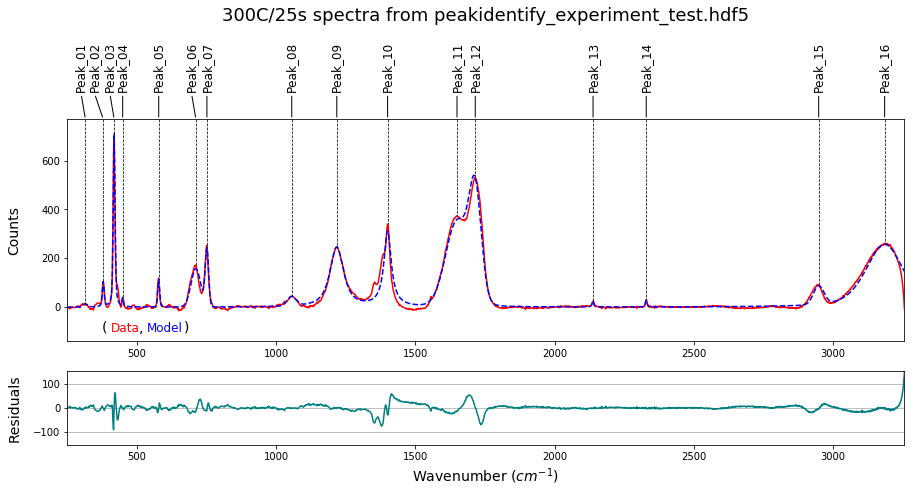

In [46]:
datavis.plot_fit('peakidentify_experiment_test.hdf5', '300C/25s')

In [47]:
dataprep.view_hdf5('peakidentify_experiment_test.hdf5')

**** peakidentify_experiment_test.hdf5 ****
300C
|    25s
|    |    Peak_01
|    |    Peak_02
|    |    Peak_03
|    |    Peak_04
|    |    Peak_05
|    |    Peak_06
|    |    Peak_07
|    |    Peak_08
|    |    Peak_09
|    |    Peak_10
|    |    Peak_11
|    |    Peak_12
|    |    Peak_13
|    |    Peak_14
|    |    Peak_15
|    |    Peak_16
|    |    counts
|    |    residuals
|    |    wavenumber


# Example 1: Peakidentify w/o wrapper

In [48]:
dataprep.new_hdf5('peakidentify_experiment_testnoadd')

In [49]:
dataprep.add_experiment('peakidentify_experiment_testnoadd.hdf5', '../ramandecompy/tests/test_files/FA_3.6wt%_300C_25s.csv')

Data from ../ramandecompy/tests/test_files/FA_3.6wt%_300C_25s.csv fit with compound pseudo-Voigt model. Results saved to peakidentify_experiment_testnoadd.hdf5.


The peaks that we found for CO2 are: 
1280.4
1385.3
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
The peaks that we found for CarbonMonoxide are: 
2139.9096496496495
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
The peaks that we found for H2O are: 
1640.6
3194.4
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
The peaks that we found for Hydrogen are: 
355.6504104104104
587.3333133133133
816.0073473473473
1035.6547747747748
[1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
The peaks that we found for sapphire are: 
378.71
418.14
575.97
751.21
[0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2.666322015842937e-06, 9.477841225773703, 314.77, 251.85262399390513, 18.955682451547407, 12.48172103404355, 251.85249801424473, "['Hydrogen']")
(0.5068130496276333, 4.012901918496308, 378.71, 1034.0055449667643, 8.025803836992615, 101.25996269002704, 1028.5886858163933, "['Hydrogen', 'sapphire']")
(0.6367815519010733, 3.8475936151059624, 418.14, 7306.162432573391, 7.695187230211925, 708

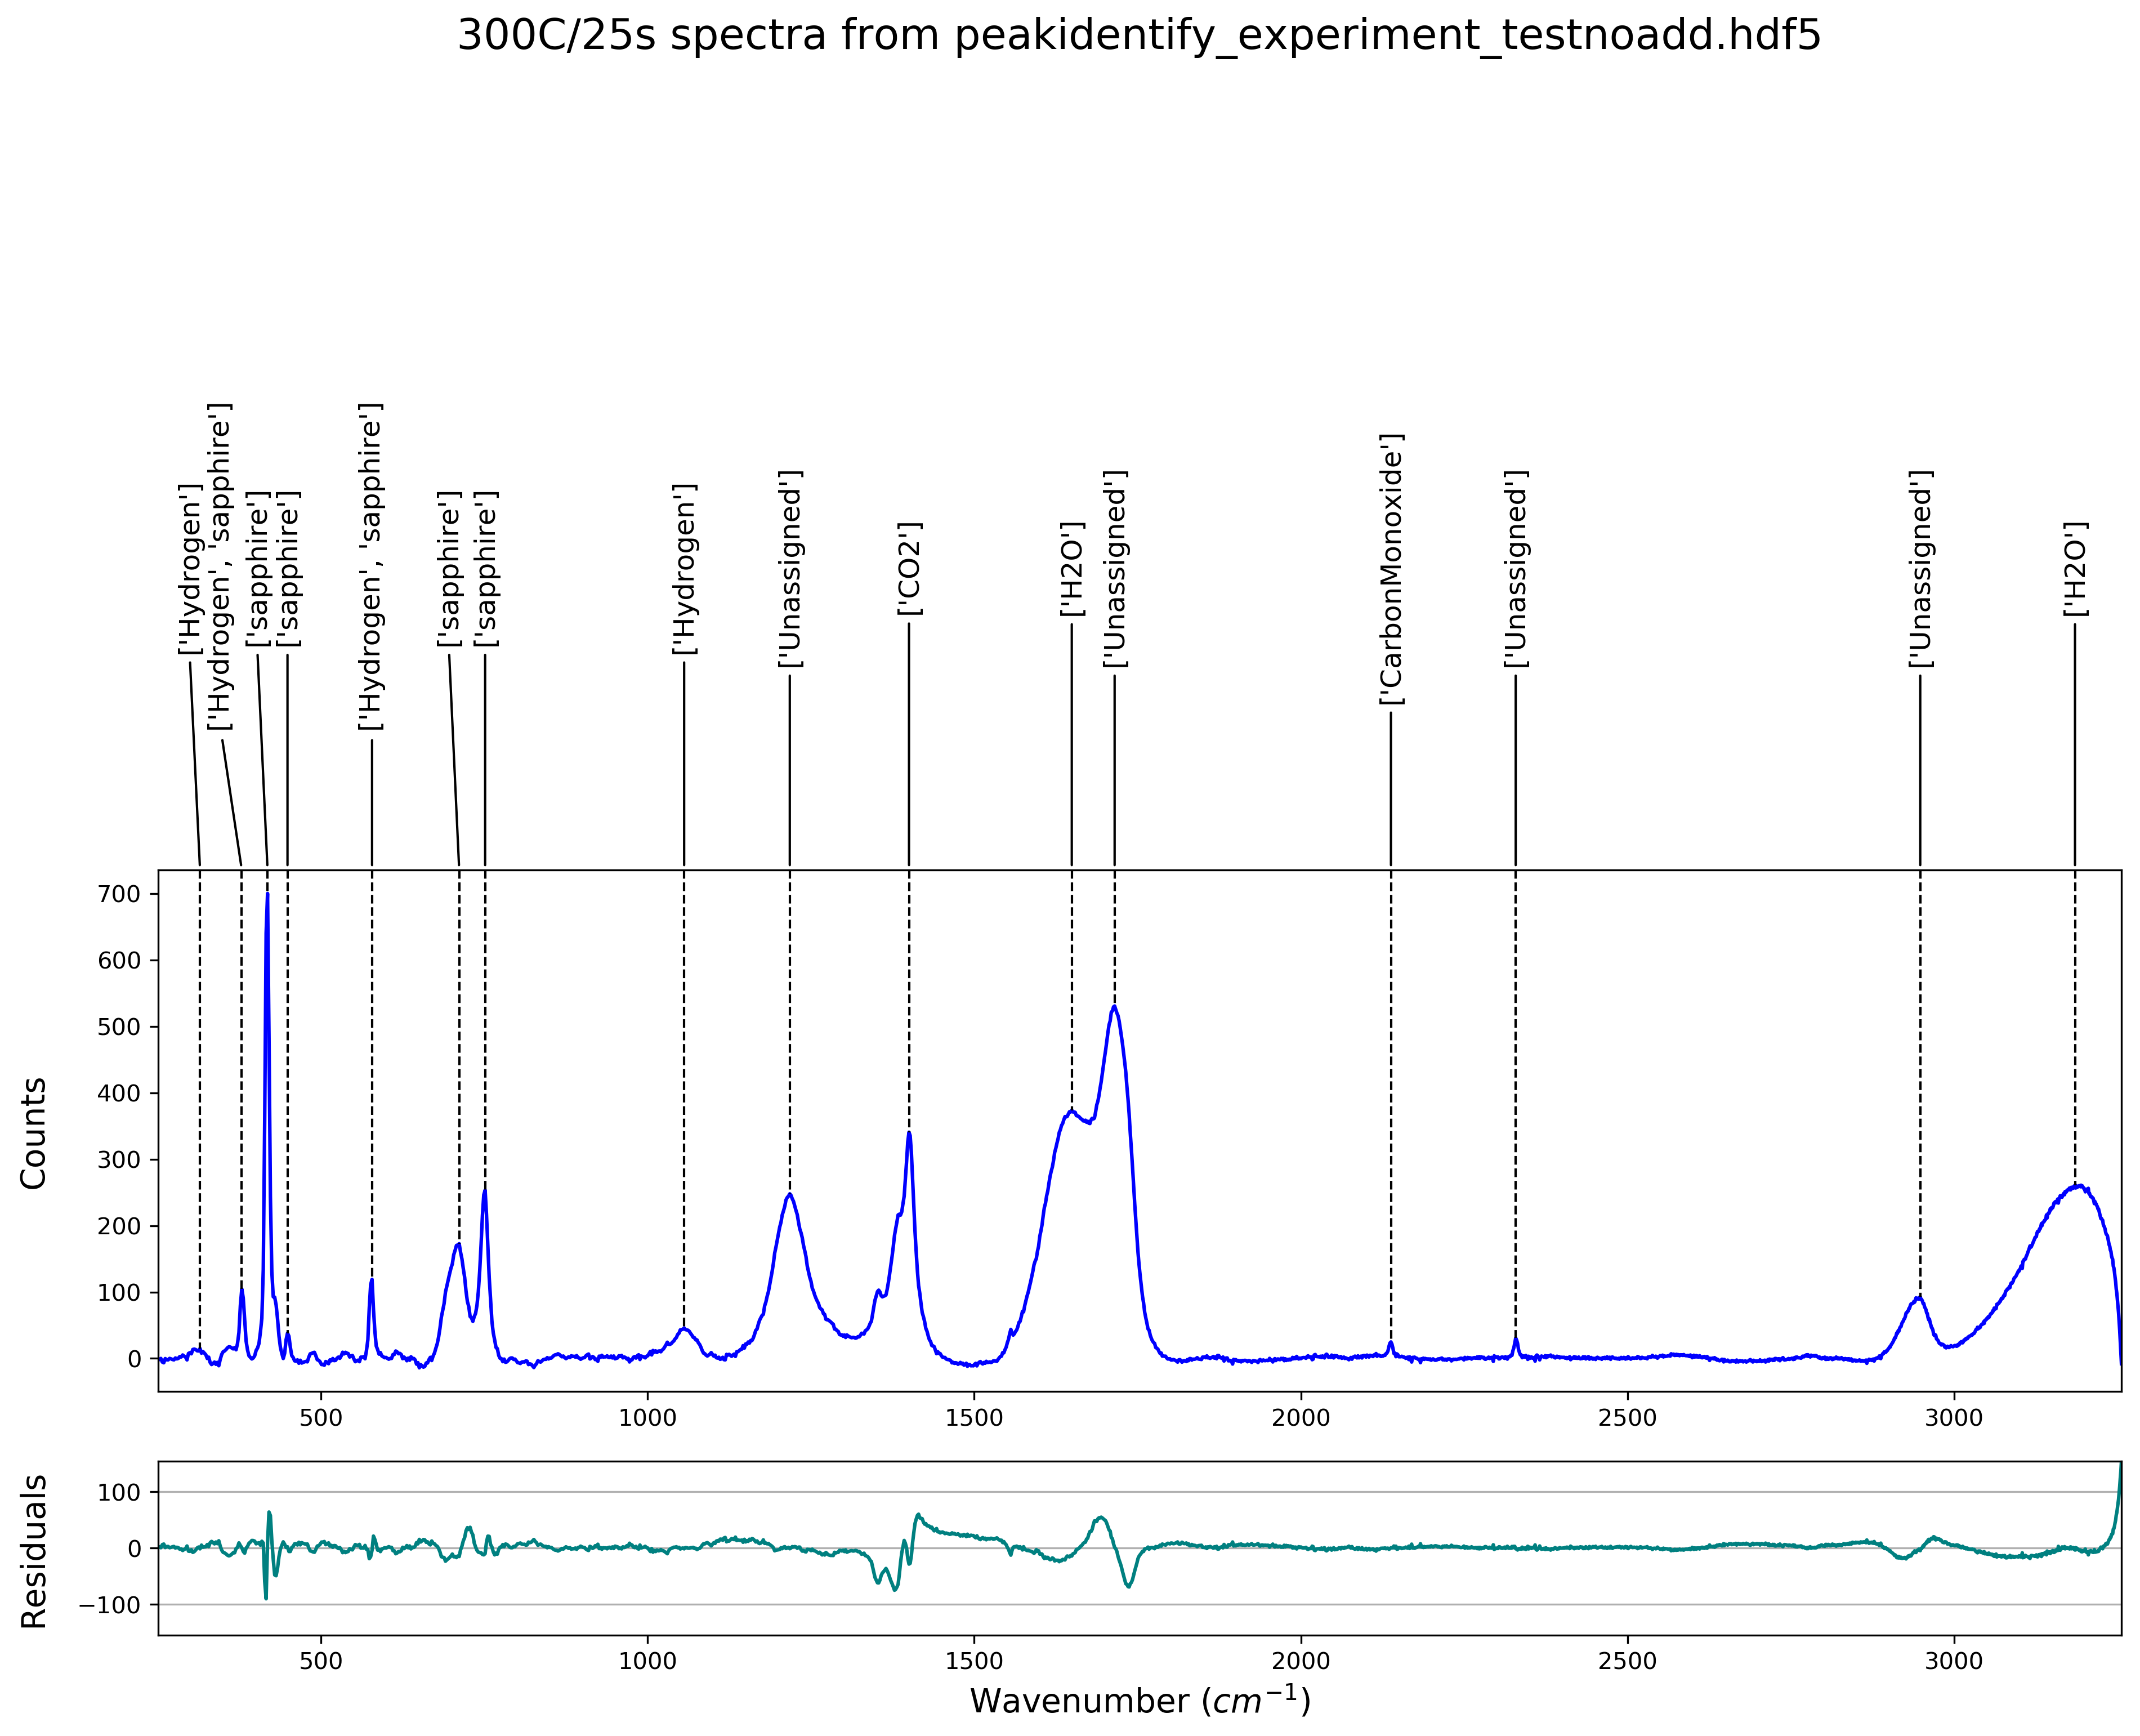

{'CO2': 50.0, 'CarbonMonoxide': 100.0, 'H2O': 100.0, 'Hydrogen': 100.0, 'sapphire': 150.0}


In [50]:
hdf5_calfilename = 'peakidentify_calibration_file.hdf5'
key = 'CarbonMonoxide'
key2 = 'Hydrogen'
key3 = 'CO2'
key4 = 'sapphire'
key5 = 'H2O'
hdf5_expfilename = 'peakidentify_experiment_testnoadd.hdf5'
expkey = '300C/25s'
temp = 300
time = 25
# open .hdf5
calhdf5 = h5py.File(hdf5_calfilename, 'r+')
exphdf5 = h5py.File(hdf5_expfilename, 'r+')
# extract spectra data
known_x = list(calhdf5['{}/wavenumber'.format(key)])
known_y = list(calhdf5['{}/counts'.format(key)])
residuals = np.asarray(list(exphdf5['{}/{}/residuals'.format(str(temp)+'C', str(time)+'s')]))
unknown_x = list(exphdf5['{}/{}/wavenumber'.format(str(temp)+'C', str(time)+'s')])
unknown_y = list(exphdf5['{}/{}/counts'.format(str(temp)+'C', str(time)+'s')])
# extract fitted peak center values
co_peaks = []
H_peaks = []
CO2_peaks = []
sapphire_peaks = []
H2O_peaks = []
unknown_peakstest = []
for _,peak in enumerate(list(calhdf5[key])[:-3]):
    co_peaks.append(list(calhdf5['{}/{}'.format(key, peak)])[0][2])

for _,peak in enumerate(list(calhdf5[key2])[:-3]):
    H_peaks.append(list(calhdf5['{}/{}'.format(key2, peak)])[0][2])
for _,peak in enumerate(list(calhdf5[key3])[:-3]):
    CO2_peaks.append(list(calhdf5['{}/{}'.format(key3, peak)])[0][2])
for _,peak in enumerate(list(calhdf5[key4])[:-3]):
    sapphire_peaks.append(list(calhdf5['{}/{}'.format(key4, peak)])[0][2])
for _,peak in enumerate(list(calhdf5[key5])[:-3]):
    H2O_peaks.append(list(calhdf5['{}/{}'.format(key5, peak)])[0][2])
for i,peak in enumerate(list(exphdf5[expkey])[:-3]):
    if i < 9:
        unknown_peakstest.append(list(exphdf5['{}/{}/Peak_0{}'.format(str(temp)+'C', str(time)+'s', i+1)])[0][2])
    else:
        unknown_peakstest.append(list(exphdf5['{}/{}/Peak_{}'.format(str(temp)+'C', str(time)+'s', i+1)])[0][2])
known_x = np.asarray(known_x)
known_y = np.asarray(known_y)
unknown_x = np.asarray(unknown_x)
unknown_y = np.asarray(unknown_y)
known_compound_list = list(calhdf5.keys())
precision = 50
known_peaks_listtest = [co_peaks, CO2_peaks, H_peaks, H2O_peaks, sapphire_peaks]
known_peakstest = []
association_matrixtest = []
# for i, _ in enumerate(known_compound_list):
#     for _,peak in enumerate(list(hdf5[key])[:-3]):
#         known_peakstest.append(known_peaks_listtest[i])
#         #print(type(known_peaks))
#         association_matrixtest.append(compare_unknown_to_known(
#             unknown_peakstest, known_peakstest[i], precision,
#             hdf5_expfilename, expkey))

        
#OK, next identify all of the peaks present in the known compound set.
    #For efficiency, we'll also compare them against the unknown in the same for loop.
known_peaks = []
known_peaks_list = []
num_peaks_list = []
assignment_matrix = []
split__index_list = []
for i, _ in enumerate(known_compound_list):
    print("The peaks that we found for "
      + str(known_compound_list[i]) + " are: ")
    num_peaks_list.append(len(list(calhdf5[known_compound_list[i]])[:-3]))
    split__index_list.append(sum(num_peaks_list))
    for j,peak in enumerate(list(calhdf5[known_compound_list[i]])[:-3]):
        print(list(calhdf5['{}/{}'.format(known_compound_list[i], peak)])[0][2])
        # Need to separate known peaks to make a list of two separate lists
        # to perform custom list split using list comprehension + zip() and split_index_list
        known_peaks_list.append(list(calhdf5['{}/{}'.format(known_compound_list[i], peak)])[0][2])
        result = [known_peaks_list[i : j] for i, j in zip([0] + split__index_list, split__index_list + [None])] 
    known_peakstest.append(result)
    association_matrixtest.append(peakidentify.compare_unknown_to_known(
        unknown_peakstest, known_peakstest[i][i], precision))        
       

unknown_peak_assignmentstest = peakidentify.peak_position_comparisons(
    unknown_peakstest,
    known_peakstest,
    association_matrixtest,
    hdf5_calfilename)
peak_labels=[]
for i, _ in enumerate(unknown_peak_assignmentstest):  
        peak_labels.append(str(unknown_peak_assignmentstest[i]))
frames = []
for j, peak in enumerate(list(exphdf5['{}C/{}s'.format(temp, time)])[:-3]):
    frames.append(pd.DataFrame(add_label(hdf5_expfilename, temp,
                                         time, peak, peak_labels[j])))

df = pd.concat(frames,axis=1, join='outer', join_axes=None, ignore_index=False,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True,sort=True)
df =df.T
peakidentify.plotting_peak_assignments(unknown_x,
                                       unknown_y,
                                       unknown_peakstest,
                                       unknown_peak_assignmentstest,
                                       hdf5_expfilename,
                                       hdf5_calfilename, temp, time, peak_labels, exportlabelinput = False )
percentages = peakidentify.percentage_of_peaks_found(known_peakstest[len(known_compound_list)-1],
                                            association_matrixtest,
                                            hdf5_calfilename)
print(percentages)
calhdf5.close()
exphdf5.close()

In [51]:
dataprep.view_hdf5('peakidentify_experiment_testnoadd.hdf5')

**** peakidentify_experiment_testnoadd.hdf5 ****
300C
|    25s
|    |    Peak_01
|    |    Peak_02
|    |    Peak_03
|    |    Peak_04
|    |    Peak_05
|    |    Peak_06
|    |    Peak_07
|    |    Peak_08
|    |    Peak_09
|    |    Peak_10
|    |    Peak_11
|    |    Peak_12
|    |    Peak_13
|    |    Peak_14
|    |    Peak_15
|    |    Peak_16
|    |    counts
|    |    residuals
|    |    wavenumber


# Example 2: Wrapper Function - peak_assignment

`peak_assignment` takes as parameters five arguments, of which 2 are optional. First, we must pass the hdf5 filename from the experiment hdf5 file, which is the `hdf5_expfilename`. The second parameter is the key from the experiment hdf5 file, which is the `expkey`. The third parameter is the the hdf5 filename from the calibration hdf5 file, which is the `hdf5_filename`. This calibration hdf5 file contains a list of all of the compounds that you want to check your unknown data for. In other words, if a compound data is not passed in this list, then the function will not look to see if that compound is present in your unknown spectrum. Each of these compounds can be refered to by the key function of the hdf5 file. The fourth parameter contains a list of strings all of the compounds that that are in that calibration file mentioned before.  This is the list that we generated above titled `list_of_compounds`, which we passed data for carbon dioxide, hydrogen, methane. An additional note is that the list of compounds from the calibration file will be listed alphabetically due to the functions of the hdf5 file format. Matching this alphabetical order is important when referencing the `list_of_compounds`. Parameter 5 is `precision`, which is an optional parameter. It is defaulted to 0.08, but can be adjusted by passing a different float value. What it does is it sets a boundary for how close the known peak position has to be to an unknown peak for the function to assign the peak. It is a percentage value, so 0.08 is 8 % of the larger of the two peak positions. The default of .08 will encompass all of the peaks in this example, but adjustments are recommended for your own experimental/calibration data. Finally, parameter 6 is `plot`, which is also an optional parameter. It is a Boolean which defaults to True. If True, this will plot the unknown specrta and labels for all of the peaks in said spectra. 

For our example, we won't mess with those optional parameters.

This function will output the list of known peaks for each compound and the plot for the unknown specrta and labels for all of the peaks in said spectra. Additionally, it will output a percentage of how many of the material's peaks are found in the unknown spectrum. This can be used as a metric of confidence.

Function did not receive adjusted peak.
            The function continued to look for an normal peak.
Peak_01
Peak_1*
Function did not receive adjusted peak.
            The function continued to look for an normal peak.
Peak_02
Peak_2*
Function did not receive adjusted peak.
            The function continued to look for an normal peak.
Peak_03
Peak_3*
Function did not receive adjusted peak.
            The function continued to look for an normal peak.
Peak_04
Peak_4*
Function did not receive adjusted peak.
            The function continued to look for an normal peak.
Peak_05
Peak_5*
Function did not receive adjusted peak.
            The function continued to look for an normal peak.
Peak_06
Peak_6*
Function did not receive adjusted peak.
            The function continued to look for an normal peak.
Peak_07
Peak_7*
Function did not receive adjusted peak.
            The function continued to look for an normal peak.
Peak_08
Peak_8*
Function did not receive adjusted peak.
        

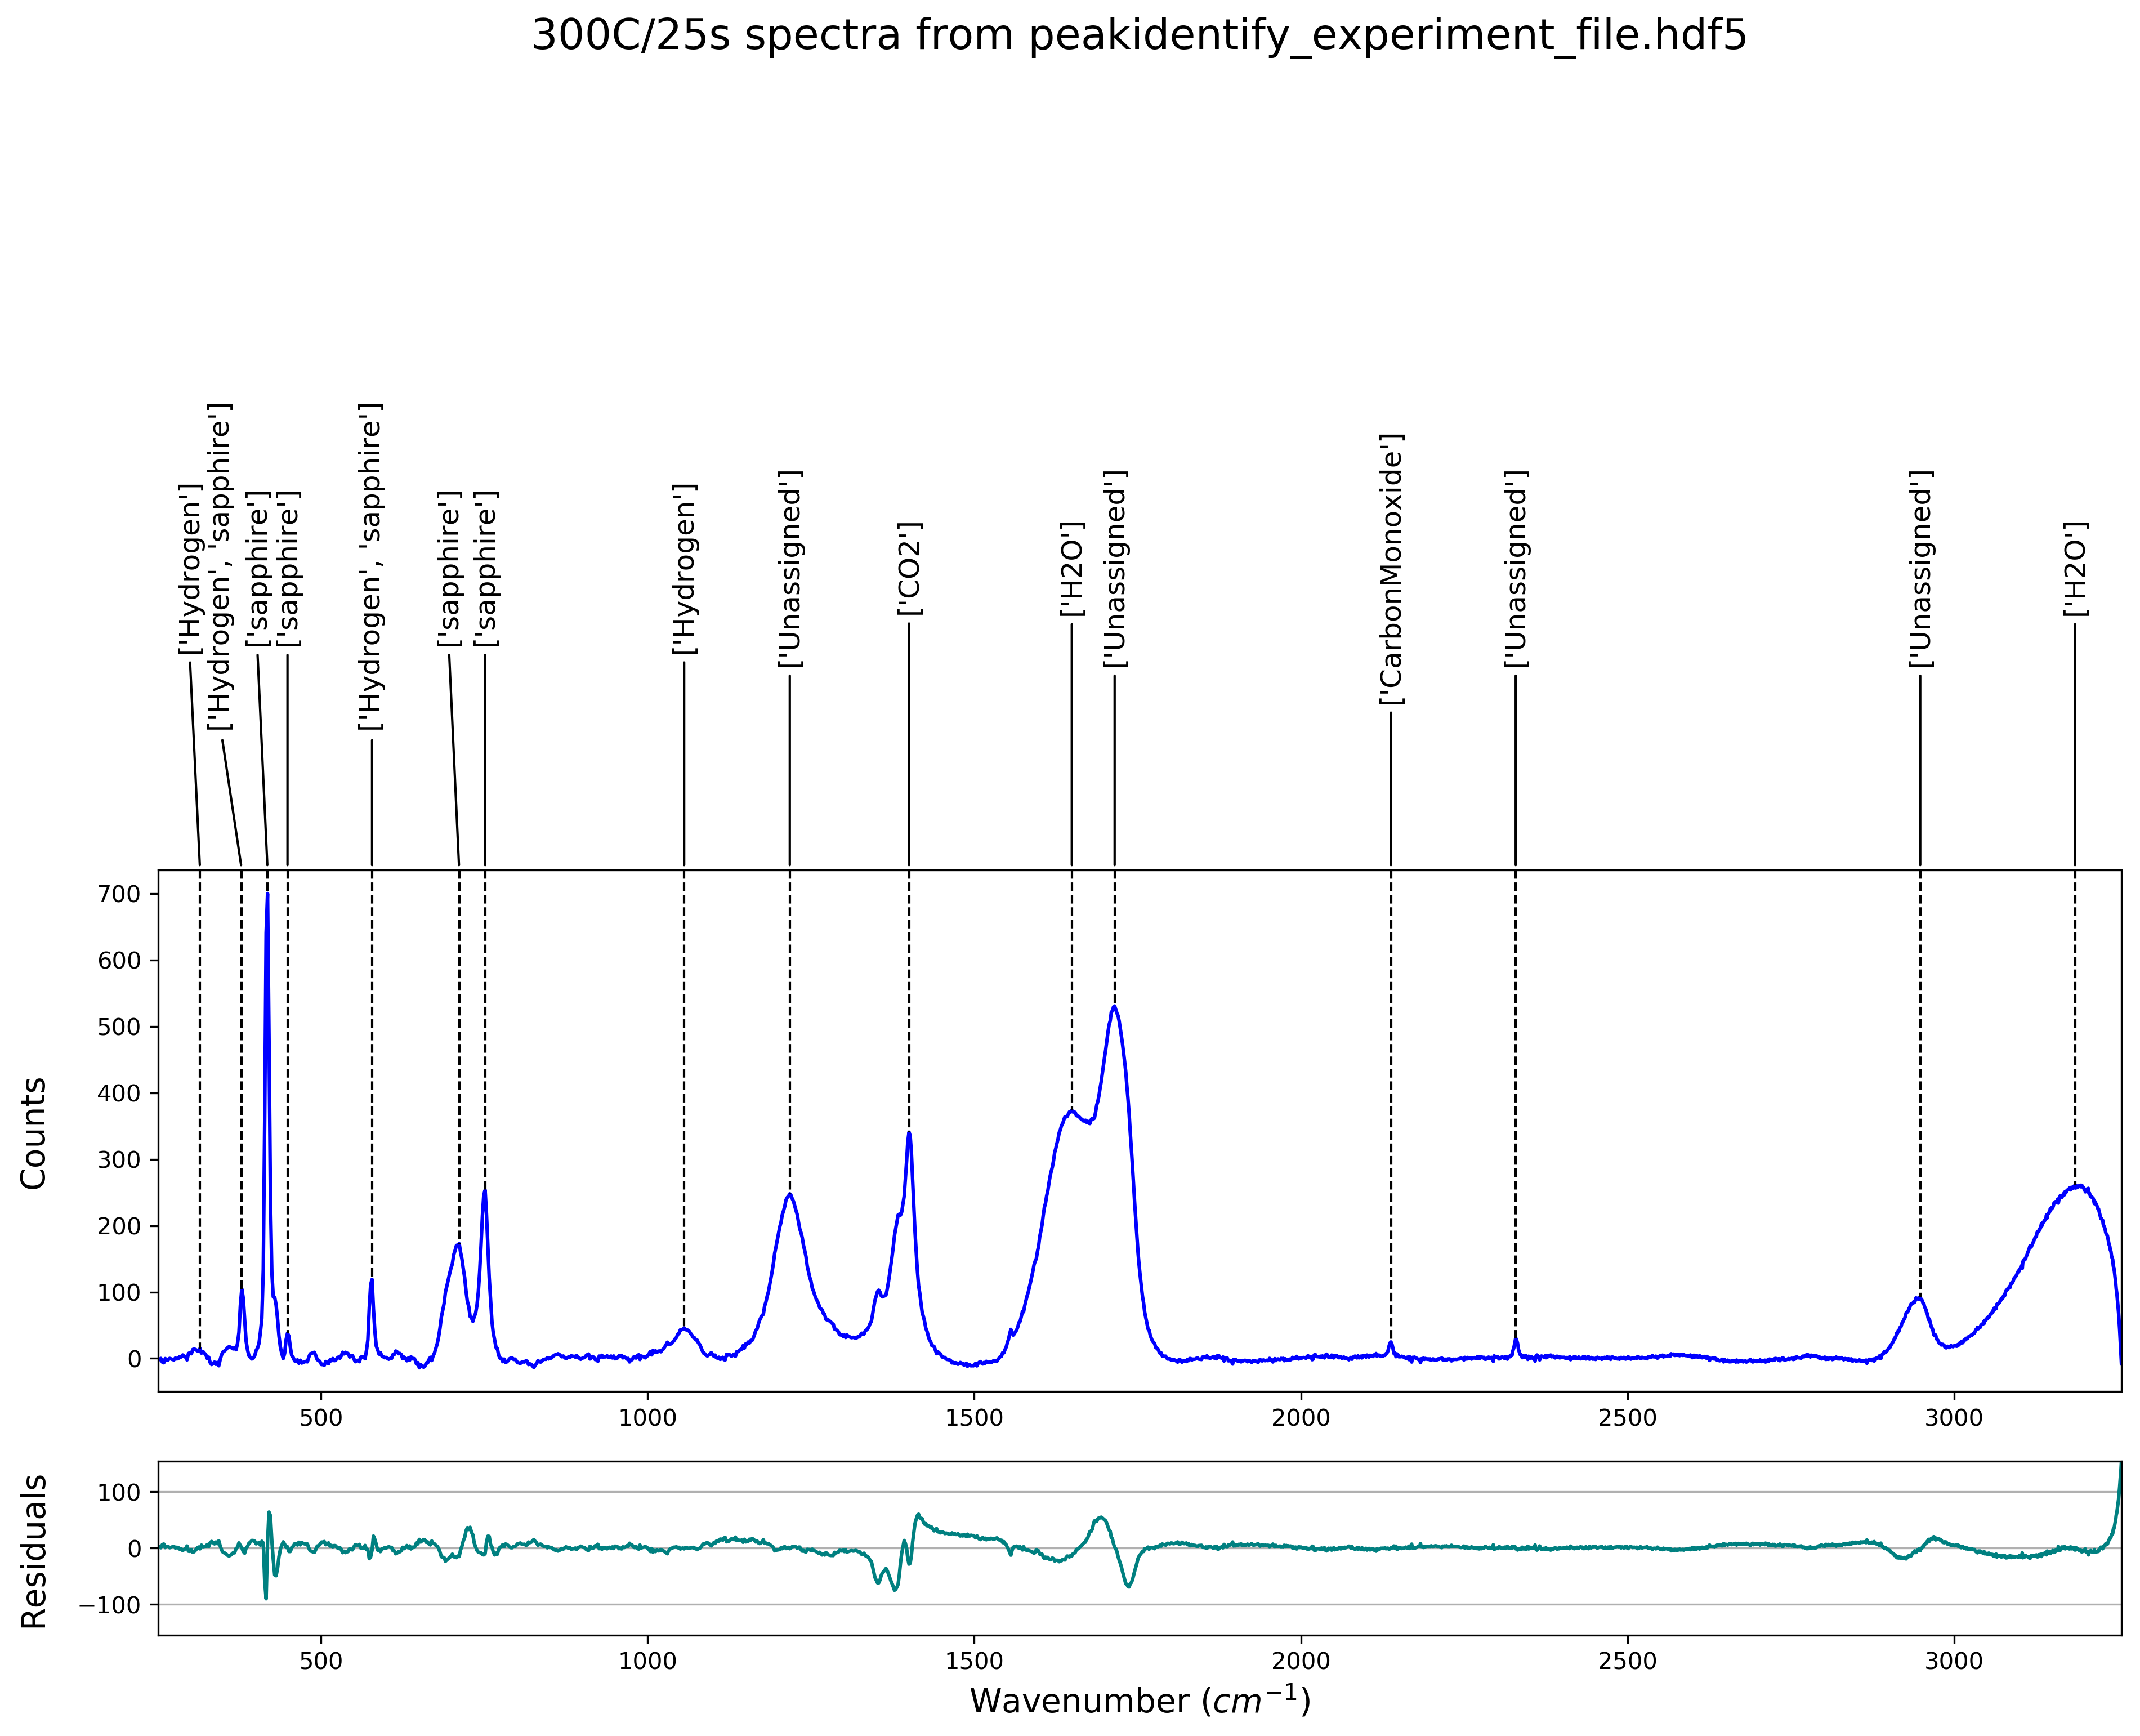

{'CO2': 50.0, 'CarbonMonoxide': 100.0, 'H2O': 100.0, 'Hydrogen': 100.0, 'sapphire': 150.0}


In [52]:
hdf5_calfilename = 'peakidentify_calibration_file.hdf5' #update to hdf5_calfilename
hdf5_expfilename = 'peakidentify_experiment_file.hdf5'
temp = 300
time = 25
unknown_x, unknown_y, unknown_peaks, unknown_peak_assignments, percentages, df = peakidentify.peak_assignment(hdf5_expfilename, temp, time, hdf5_calfilename, 50)

**** peakidentify_experiment_file.hdf5 ****
300C
|    25s
|    |    Peak_01
|    |    Peak_02
|    |    Peak_03
|    |    Peak_04
|    |    Peak_05
|    |    Peak_06
|    |    Peak_07
|    |    Peak_08
|    |    Peak_09
|    |    Peak_10
|    |    Peak_11
|    |    Peak_12
|    |    Peak_13
|    |    Peak_14
|    |    Peak_15
|    |    Peak_16
|    |    counts
|    |    residuals
|    |    wavenumber


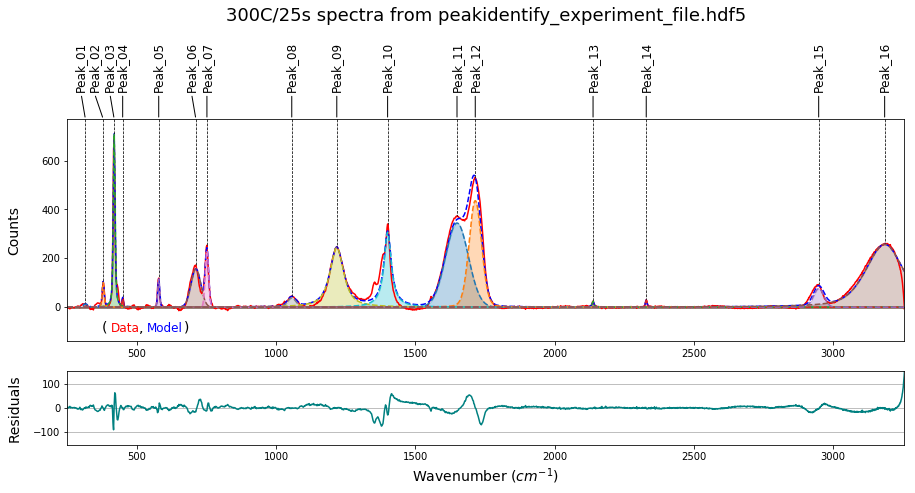

In [53]:
key = '300C/25s'
dataprep.view_hdf5('peakidentify_experiment_file.hdf5')
fig, ax1, ax2 = datavis.plot_fit(hdf5_expfilename, key)
datavis.plot_components(ax1, hdf5_filename, key, [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

### Note:
Because plot = True, we see a plot of our unknown spectra with lines indicating the positions of identified possible components. 

To provide additional clarity as to the likelihood of which peaks are correctly assigned, and which are not, a dictionary is printed out after showing the plot. The dictionary contains the name of the compound, followed by a percentage. The percentage is generated by comparing the total number of peaks in the Raman spectra that are found in the unknown spectra. For example, if 1 peak out of 10 possible are found as is the case for carbon dioxide above, it will show a percentage of 10%, whereas for water if it find 3 peaks out of a possible 3, the percentage reported is 100%. This percentage provides an approximate degree of confidence for how likely it is that a compound is present. 

For this above example, because we see that water and carbon monoxide show a 100% detection percentage, we're quite confident that they are in-fact present in our unknown sample; however, as carbon dioxide only shows a 10% detection percentage, it's not very likely that it is present in our unknown sample. That said, the final value judgement is left to the user, as these percentages are just approximate guidelines. 

***

# Example 3 - Individual Functions of `peakidentify.py`


Now that you've seen the broad usage of peakidentify.py, we'll walk through the individual functions and spend a bit more time really explaining each individual use-case.

You have already been introduced to the first function, a wrapper function called peak_assignment. Following this, the next function is compare_unknown_to_known. This function takes in the peak positions (the wavenumber position for the peak position) for the unknown's spectrum, and compares it to the peaks positions for a single known compound. 

compare_unknown_to_known takes 3 parameters. The first parameter, combined_peaks is the peak positions of the unknown peaks. The second parameter, known_peaks, is the peak positions of one of the known compounds. The third parameter is precision, which is the maximum percentage difference between an unknown peak position and a known peak position that will be accepted as close enough to give a positive assignment. The function returns a parameter association_matrix, which contains a list of either 1 or 0, which is the assignment value of whether or not a peak from the unknown peak set was found in the passed known peak set. 

We'll need to generate some data to pass along, then call the function directly.

In [54]:
peakidentify.compare_unknown_to_known(unknown_peaks, H_peaks, 50)

[1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


array([1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [55]:
peakidentify.compare_unknown_to_known(unknown_peaks, co_peaks, 50)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

In [56]:
peakidentify.compare_unknown_to_known(unknown_peaks, CO2_peaks, 50)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [57]:
peakidentify.compare_unknown_to_known(unknown_peaks, sapphire_peaks, 50)

[0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


array([0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [58]:
peakidentify.compare_unknown_to_known(unknown_peaks, H2O_peaks, 50)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.])

So, this function, when called to compare water to the unknown peaks, or carbon monoxide to the unknown peaks, we see that it returns an array of 1 and 0. This array is an assignment array. If the array contains a 0, the peak in that position is not found in the known compound. For example, for the water peak comparison, the value of the returned array is 1 at position 0. That means that it is assigning the peak found at position 0 to be possibly coming from water. The 0 in position 2 implies that the unknown peak is not found in water. If we look at position 2 in the carbon monoxide comparison, we see that it is a 1 there. This implies that the peak in position 2, is likely not coming from water, and could possibly be coming from carbon monoxide.

The next function to investigate is the `peak_position_comparisons`. It takes four parameters. The first is the list of unknown peaks, and the second is the complete list of peaks for known compounds. The third is the list of compounds that the wrapper function should search through. The fourth is the complete association matrix output from the `compare_unknown_to_known` function. By appending together the matrices returned by that function, the full association_matrix is built. We will build a full association matrix, and then pass it to our `peak_position_comparisons` function.

In [59]:
#Build our test data.
association_matrix_beta = []
known_peaks_beta = [co_peaks, CO2_peaks, H_peaks, H2O_peaks, sapphire_peaks]
# Note the order that you append to the association_matrix_beta matters 
# with the known compound list so make sure these match alphabetically
# Known peaks beta, order does not matter
association_matrix_beta.append(peakidentify.compare_unknown_to_known(unknown_peaks, co_peaks, 50))
association_matrix_beta.append(peakidentify.compare_unknown_to_known(unknown_peaks, CO2_peaks, 50))
association_matrix_beta.append(peakidentify.compare_unknown_to_known(unknown_peaks, H_peaks, 50))
association_matrix_beta.append(peakidentify.compare_unknown_to_known(unknown_peaks, H2O_peaks, 50))
association_matrix_beta.append(peakidentify.compare_unknown_to_known(unknown_peaks, sapphire_peaks, 50))

print(association_matrix_beta)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
[0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]), array([0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]


In [60]:
known_compound_list

['CO2', 'CarbonMonoxide', 'H2O', 'Hydrogen', 'sapphire']

In [61]:
known_peakstest

[[[1280.4, 1385.3], []],
 [[1280.4, 1385.3], [2139.9096496496495], []],
 [[1280.4, 1385.3], [2139.9096496496495], [1640.6, 3194.4], []],
 [[1280.4, 1385.3],
  [2139.9096496496495],
  [1640.6, 3194.4],
  [355.6504104104104,
   587.3333133133133,
   816.0073473473473,
   1035.6547747747748],
  []],
 [[1280.4, 1385.3],
  [2139.9096496496495],
  [1640.6, 3194.4],
  [355.6504104104104,
   587.3333133133133,
   816.0073473473473,
   1035.6547747747748],
  [378.71, 418.14, 575.97, 751.21],
  []]]

In [62]:
peakidentify.peak_position_comparisons(unknown_peaks, known_peaks_beta[len(known_compound_list)-1], association_matrix_beta, hdf5_calfilename)

[['H2O'],
 ['H2O'],
 ['Unassigned'],
 ['Unassigned'],
 ['H2O'],
 ['Unassigned'],
 ['Unassigned'],
 ['H2O'],
 ['Unassigned'],
 ['CarbonMonoxide'],
 ['Hydrogen'],
 ['Unassigned'],
 ['CO2'],
 ['Unassigned'],
 ['Unassigned'],
 ['Hydrogen']]

This function returns a list that shows all of the possible assignments for every peak, in a text format. We can see that for the unknown peak in position 0, there is a potential for that peak to have come from Hydrogen or Methane, whereas the peak in position 2, is labelled as Hydrogen. If this function does not find any possible compound for a peak, it returns a value of 'unassigned', which we will show below. PLEASE check matrix

In [63]:
peakidentify.peak_position_comparisons(unknown_peaks, [co_peaks], [[1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], hdf5_calfilename)

[['CO2'],
 ['Unassigned'],
 ['CO2'],
 ['CO2'],
 ['CO2'],
 ['Unassigned'],
 ['Unassigned'],
 ['CO2'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned']]

In [64]:
peakidentify.peak_position_comparisons(unknown_peaks, [CO2_peaks],[[0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], hdf5_calfilename)

[['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['CO2'],
 ['Unassigned'],
 ['Unassigned'],
 ['CO2'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned']]

In [65]:
peak_position_comparisons(unknown_peaks, [H_peaks], [[1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], hdf5_calfilename)

[['CO2'],
 ['Unassigned'],
 ['CO2'],
 ['CO2'],
 ['CO2'],
 ['Unassigned'],
 ['Unassigned'],
 ['CO2'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned']]

In [66]:
peakidentify.peak_position_comparisons(unknown_peaks, [H2O_peaks],[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], hdf5_calfilename)

[['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['CO2']]

In [67]:
peakidentify.peak_position_comparisons(unknown_peaks, [sapphire_peaks],[[0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], hdf5_calfilename)

[['Unassigned'],
 ['CO2'],
 ['Unassigned'],
 ['Unassigned'],
 ['CO2'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned']]

As you can see, if the peak isn't found, it labels the value as 'unassigned'! 

Additionally, the association matrix list of 1s and 0s directly correlates to the list of possible assignments, thus changes in the matrix will affect the possible assignments.



The next function to be explored is `percentage_of_peaks_found`. This function calculates a percentage value for how many of the peaks from a known compound were found in the unknown peak list. This function takes 3 parameters. The first is a list of known peaks, the second is the full association matrix, and the third is the list of known compounds, as a list of dictionaries. The function returns a dictionary where the keys are all of the titles of the known compounds, and the values of the keys are all of the percentages of found peaks.

In [68]:
# Test pecentage of peaks found case
# Adding random lists not associated with the known compound list will throw off the calculations of found peak percent
peakidentify.percentage_of_peaks_found([co_peaks, CO2_peaks, [1], H_peaks, H2O_peaks, sapphire_peaks], 
                          association_matrix_beta, hdf5_calfilename)

{'CO2': 100.0,
 'CarbonMonoxide': 50.0,
 'H2O': 400.0,
 'Hydrogen': 50.0,
 'sapphire': 300.0}

In [69]:
# THe known peaks found must match the order from the known_compound_list
peakidentify.percentage_of_peaks_found([co_peaks, CO2_peaks, H_peaks, H2O_peaks, sapphire_peaks], 
                          association_matrix_beta, hdf5_calfilename)

{'CO2': 100.0,
 'CarbonMonoxide': 50.0,
 'H2O': 100.0,
 'Hydrogen': 100.0,
 'sapphire': 150.0}

In [70]:
peakidentify.percentage_of_peaks_found(known_peaks_beta, 
                          association_matrix_beta, hdf5_calfilename)

{'CO2': 100.0,
 'CarbonMonoxide': 50.0,
 'H2O': 100.0,
 'Hydrogen': 100.0,
 'sapphire': 150.0}

In [71]:
peakidentify.percentage_of_peaks_found([co_peaks,[0], [0], [0],[0] ], 
                          association_matrix_beta, hdf5_calfilename)

{'CO2': 100.0,
 'CarbonMonoxide': 100.0,
 'H2O': 400.0,
 'Hydrogen': 200.0,
 'sapphire': 600.0}

Ok, above you can see that 100% of the peaks of water are found, as are 100% of the carbon monoxide peaks. This is pretty reasonable, as the unknown spectra was made up of water and carbon monoxide, and it's a good sign. There is a 10% find-rate for carbon dioxide. If we look at the absolute peak positions for carbon dioxide, we see that this is pretty reasonable, as one of the peaks of carbon dioxide closely overlaps with the first peak of water. However, none of the other carbon dioxide peaks overlap, so overall we get a pretty low percentage of carbon dioxide peaks found. Ultimately, it is up to the user to be sure that the percentages and compound list make sense, and to interpret what the percentages mean.

The next function in the peakidentify system is the `plotting_peak_assignments` function, which plot the full unknown spectra, and labels each of the peaks in the unknown spectra with all of the possible compounds present. It takes as inputs 4 parameters. The first is the unknown_x data from before, and the second is the unknown_y data, also from before. The third input is the list of unknown peaks, and the fourth input is the list of assignments for each of those unknown peaks. It does not return any values, but it does generate a plot of all of the input information. 

[['H2O'], ['H2O', 'sapphire'], ['sapphire'], ['sapphire'], ['H2O', 'sapphire'], ['sapphire'], ['sapphire'], ['H2O'], ['Unassigned'], ['CarbonMonoxide'], ['Hydrogen'], ['Unassigned'], ['CO2'], ['Unassigned'], ['Unassigned'], ['Hydrogen']]
["['H2O']", "['H2O', 'sapphire']", "['sapphire']", "['sapphire']", "['H2O', 'sapphire']", "['sapphire']", "['sapphire']", "['H2O']", "['Unassigned']", "['CarbonMonoxide']", "['Hydrogen']", "['Unassigned']", "['CO2']", "['Unassigned']", "['Unassigned']", "['Hydrogen']"]


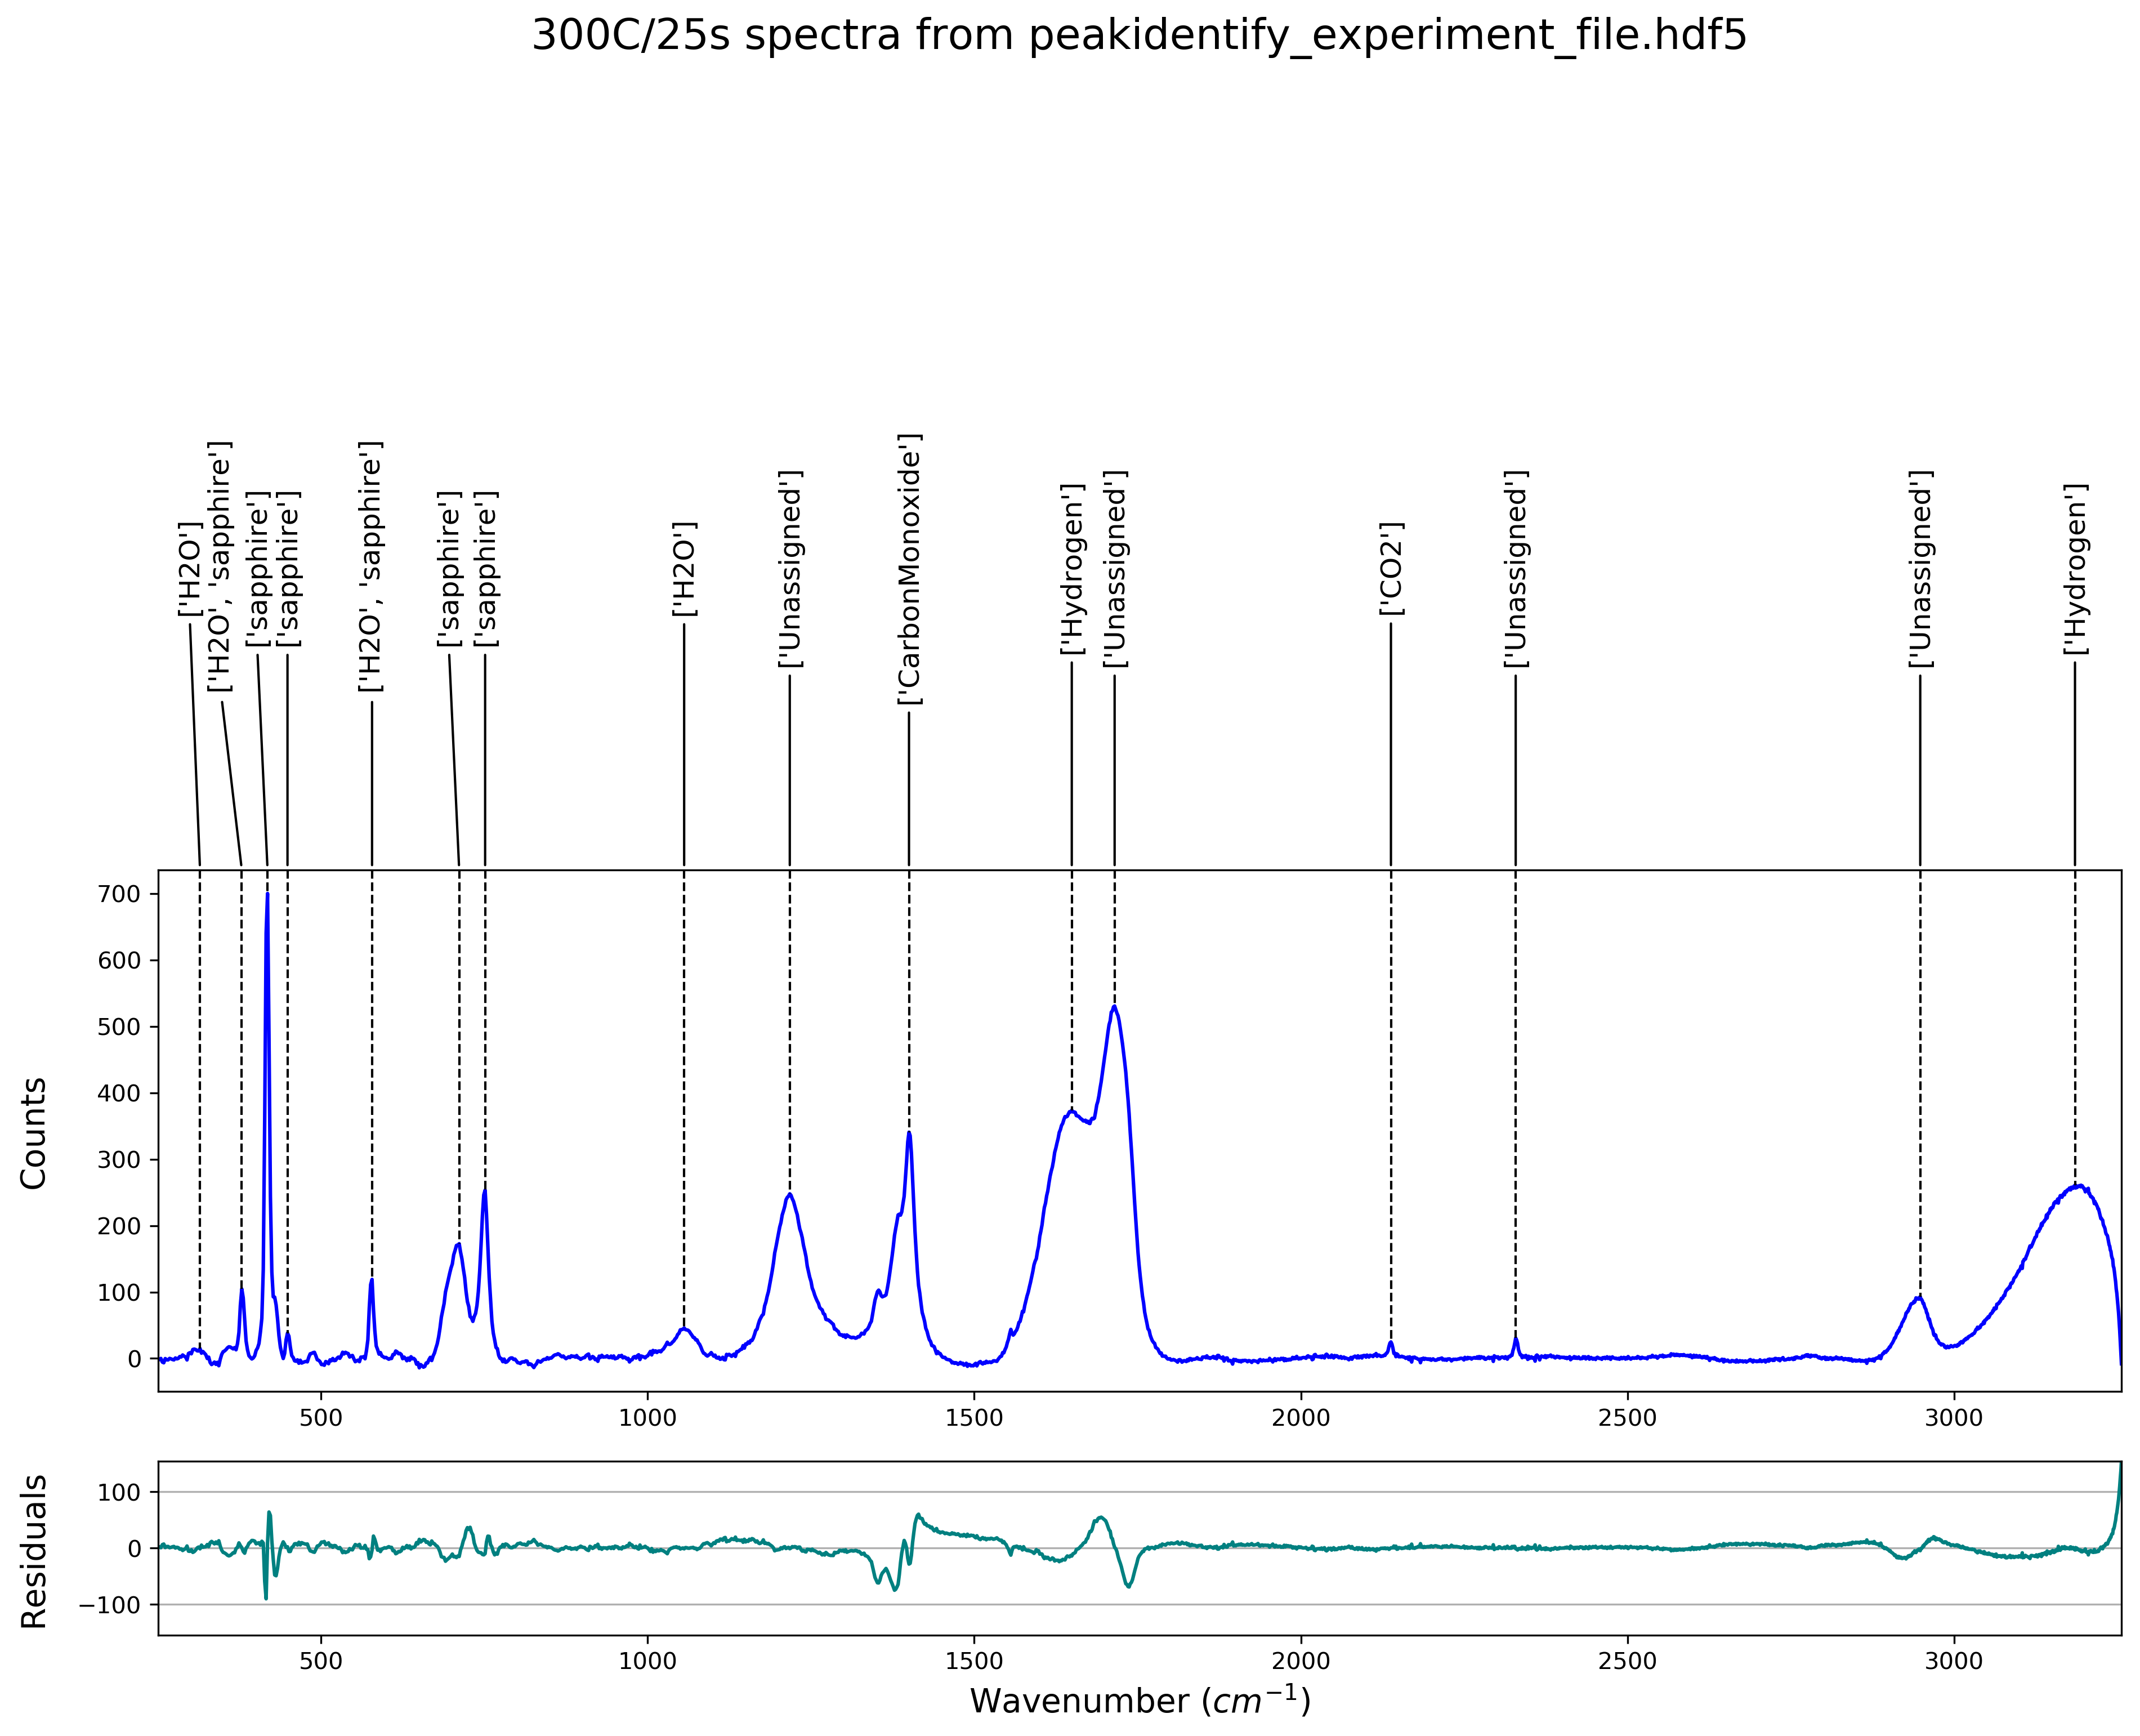

In [72]:
unknown_peak_assignments_beta = peakidentify.peak_position_comparisons(unknown_peakstest, known_peaks_beta, association_matrix_beta, hdf5_calfilename)
print(unknown_peak_assignments_beta)
peakidentify.plotting_peak_assignments(unknown_x, unknown_y, unknown_peaks, unknown_peak_assignments_beta, hdf5_expfilename, hdf5_calfilename, temp, time, peak_labels, exportlabelinput = False )

Here, we see the exact same plot as above, when we just interacted with the wrapper function. Ultimately, the plot generated should be exactly the same, given that it was generated using the same data. 
You can change the inputs for the known peaks, but you need to make sure your list of compounds is alphabetical.

# Example 4: Demonstration of Two Peaks on top of each other
(A) For each of vertical line, you can see that the peak labelling function has assigned not just one, but two possible peaks to this position. This is possible with chemicals that have common degradation derivatives.

In the demo below of two peaks sharing one spot, the association matrix has been modified to add CO2 and Hydrogen peaks together in the 2nd peak placement, therefore the label shows CO2&Hydrogen.

(B) In the future, there might be instances with two peaks peaks that exist in similar locations within the `precision` error bound. 

To provide additional clarity as to the likelihood of which peaks are correctly assigned, and which are not, a dictionary is printed out after showing the plot. The dictionary contains the name of the compound, followed by a percentage. The percentage is generated by comparing the total number of peaks in the Raman spectra that are found in the unknown spectra. For example, if 1 peak out of 10 possible are found as is the case for carbon dioxide above, it will show a percentage of 10%, whereas for water if it find 3 peaks out of a possible 3, the percentage reported is 100%. This percentage provides an approximate degree of confidence for how likely it is that a compound is present. 

For this above example, because we see that water and carbon monoxide show a 100% detection percentage, we're quite confident that they are in-fact present in our unknown sample; however, as carbon dioxide only shows a 10% detection percentage, it's not very likely that it is present in our unknown sample. That said, the final value judgement is left to the user, as these percentages are just approximate guidelines. 

***

In [73]:
#Build our test data.
known_peaks_beta = [co_peaks, CO2_peaks, H_peaks, H2O_peaks, sapphire_peaks]
# Note the order that you append to the association_matrix_beta matters 
# with the known compound list so make sure these match alphabetically
# Known peaks beta, order does not matter
association_matrix_gamma = [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], [1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.], [0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]
print(association_matrix_gamma)

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]


[['H2O'], ['H2O', 'sapphire'], ['sapphire'], ['sapphire'], ['H2O', 'sapphire'], ['sapphire'], ['sapphire'], ['H2O'], ['Unassigned'], ['CarbonMonoxide'], ['Hydrogen'], ['Unassigned'], ['CO2'], ['Unassigned'], ['Unassigned'], ['Hydrogen']]
["['H2O']", "['H2O', 'sapphire']", "['sapphire']", "['sapphire']", "['H2O', 'sapphire']", "['sapphire']", "['sapphire']", "['H2O']", "['Unassigned']", "['CarbonMonoxide']", "['Hydrogen']", "['Unassigned']", "['CO2']", "['Unassigned']", "['Unassigned']", "['Hydrogen']"]


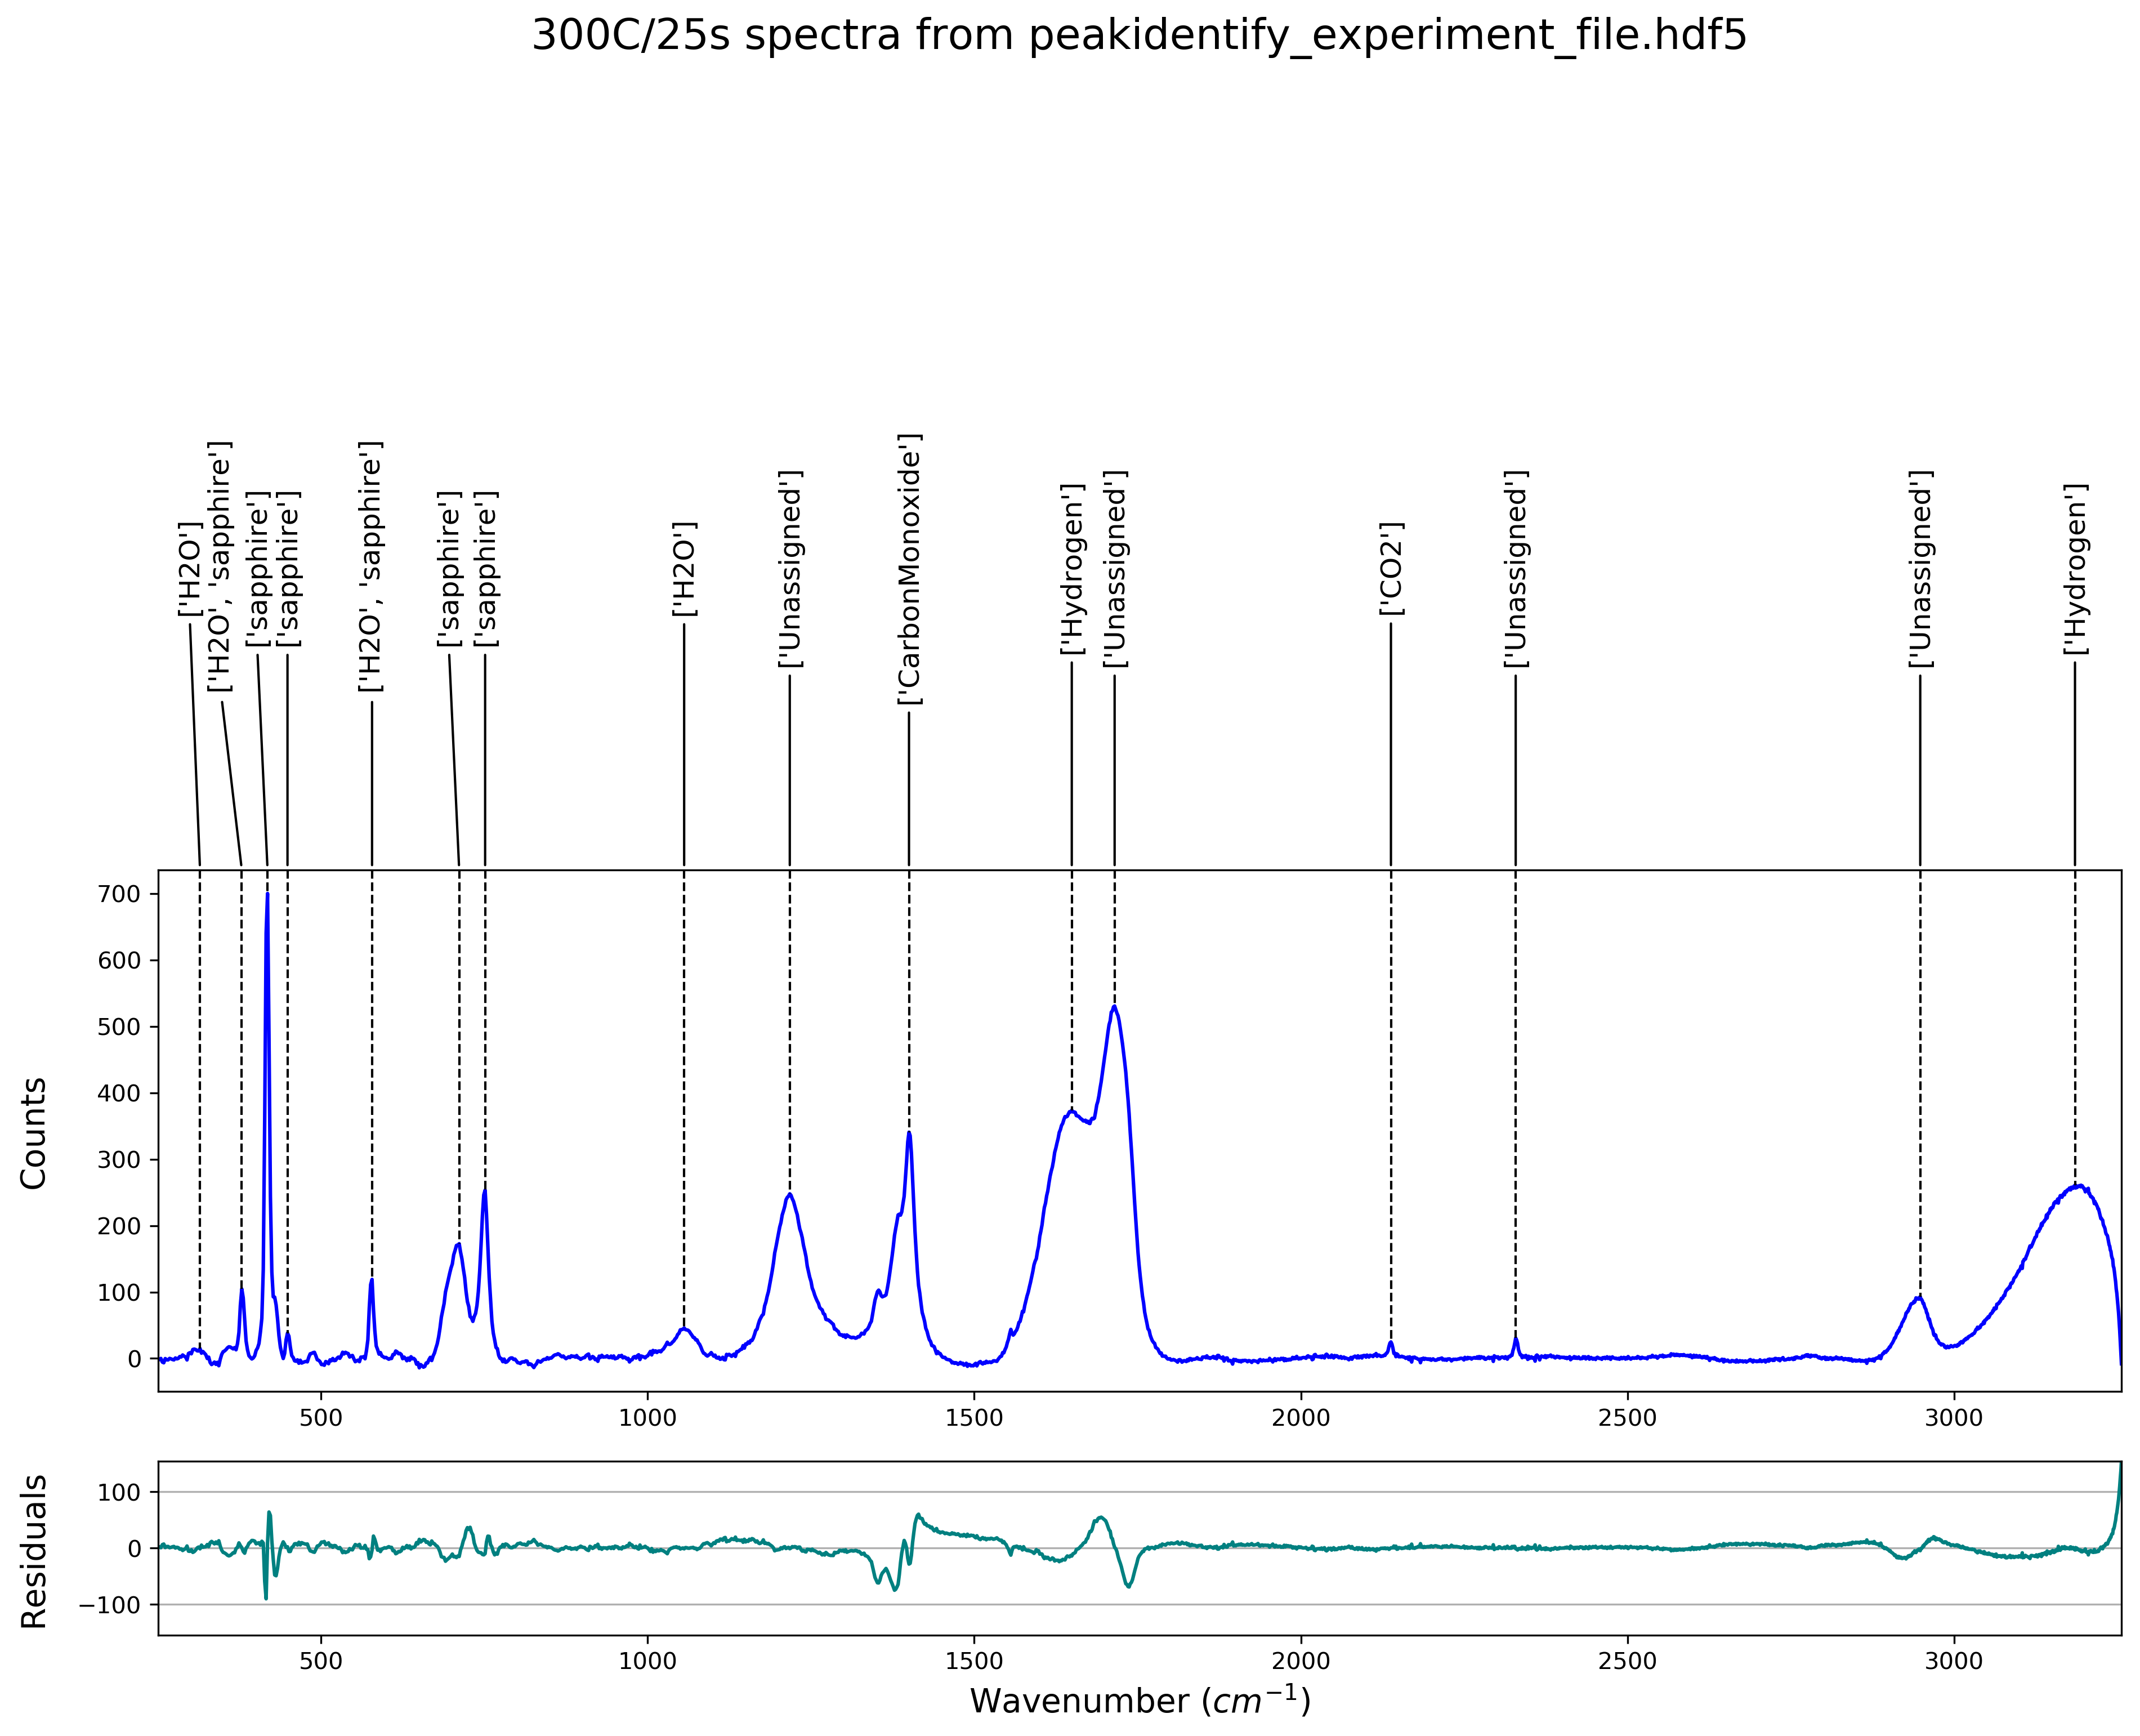

In [74]:
unknown_peak_assignments_gamma = peakidentify.peak_position_comparisons(unknown_peakstest, known_peaks_beta, association_matrix_gamma, hdf5_calfilename)
print(unknown_peak_assignments_gamma)
peakidentify.plotting_peak_assignments(unknown_x, unknown_y, unknown_peakstest, unknown_peak_assignments_gamma, hdf5_expfilename, hdf5_calfilename, temp, time, peak_labels, exportlabelinput = False )

# Example 5: Peakidentify adjusting peaks

In [75]:
# when you add a new hdf5 file you use this function below
dataprep.new_hdf5('peakidentify_adjust_peaks')

In [76]:
hdf5_filename = 'peakidentify_adjust_peaks.hdf5'
key = '300C/25s'


In [77]:
dataprep.add_experiment(hdf5_filename, '../ramandecompy/tests/test_files/FA_3.6wt%_300C_25s.csv')
# dataprep.add_experiment(hdf5_filename, '../ramandecompy/tests/test_files/FA_3.6wt%_300C_35s.csv')
# dataprep.add_experiment(hdf5_filename, '../ramandecompy/tests/test_files/FA_3.6wt%_300C_45s.csv')
# dataprep.add_experiment(hdf5_filename, '../ramandecompy/tests/test_files/FA_3.6wt%_300C_55s.csv')
# dataprep.add_experiment(hdf5_filename, '../ramandecompy/tests/test_files/FA_3.6wt%_300C_65s.csv')

Data from ../ramandecompy/tests/test_files/FA_3.6wt%_300C_25s.csv fit with compound pseudo-Voigt model. Results saved to peakidentify_adjust_peaks.hdf5.


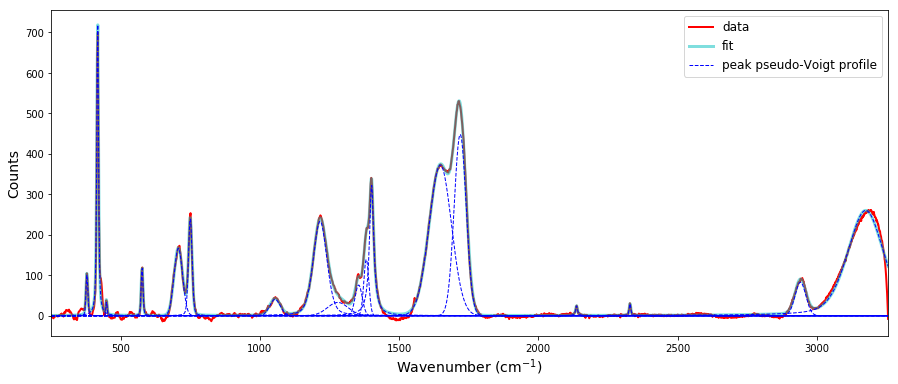

In [78]:
add_list = [1270, 1350, 1385]#, 1640]
# add_list = None
drop_list = ['Peak_01']#, 'Peak_02']
# drop_list = None

dataprep.adjust_peaks(hdf5_filename, key, add_list, drop_list, plot_fits=True)

**** peakidentify_adjust_peaks.hdf5 ****
300C
|    25s
|    |    Peak_01
|    |    Peak_02
|    |    Peak_03
|    |    Peak_04
|    |    Peak_05
|    |    Peak_06
|    |    Peak_07
|    |    Peak_08
|    |    Peak_09*
|    |    Peak_10*
|    |    Peak_11*
|    |    Peak_12
|    |    Peak_13
|    |    Peak_14
|    |    Peak_15
|    |    Peak_16
|    |    Peak_17
|    |    Peak_18
|    |    counts
|    |    residuals
|    |    wavenumber


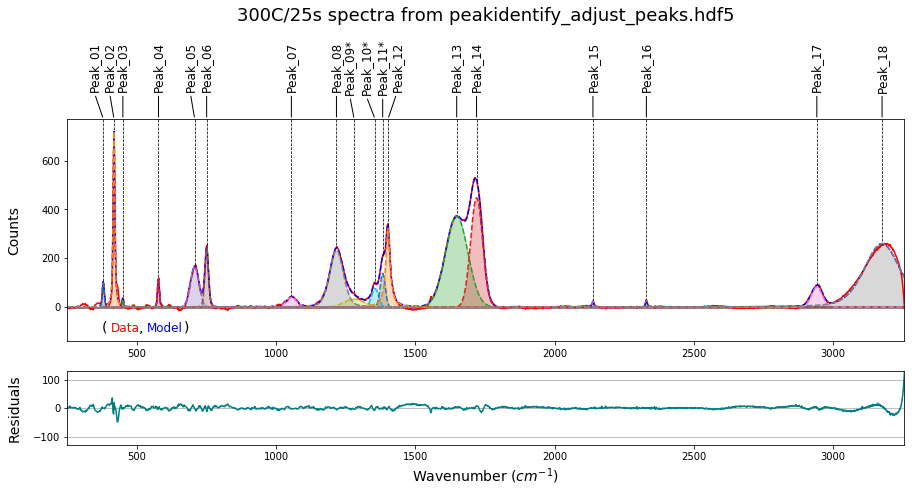

In [79]:
dataprep.view_hdf5(hdf5_filename)
fig, ax1, ax2 = datavis.plot_fit(hdf5_filename, key)
datavis.plot_components(ax1, hdf5_filename, key, [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])

In [80]:
# hdf5 = h5py.File(hdf5_filename, 'r+')
# del hdf5['300C/35s']
# hdf5.close()

Function did not receive adjusted peak.
            The function continued to look for an normal peak.
Peak_01
Peak_1*
Function did not receive adjusted peak.
            The function continued to look for an normal peak.
Peak_02
Peak_2*
Function did not receive adjusted peak.
            The function continued to look for an normal peak.
Peak_03
Peak_3*
Function did not receive adjusted peak.
            The function continued to look for an normal peak.
Peak_04
Peak_4*
Function did not receive adjusted peak.
            The function continued to look for an normal peak.
Peak_05
Peak_5*
Function did not receive adjusted peak.
            The function continued to look for an normal peak.
Peak_06
Peak_6*
Function did not receive adjusted peak.
            The function continued to look for an normal peak.
Peak_07
Peak_7*
Function did not receive adjusted peak.
            The function continued to look for an normal peak.
Peak_08
Peak_8*
Function did not receive adjusted peak.
        

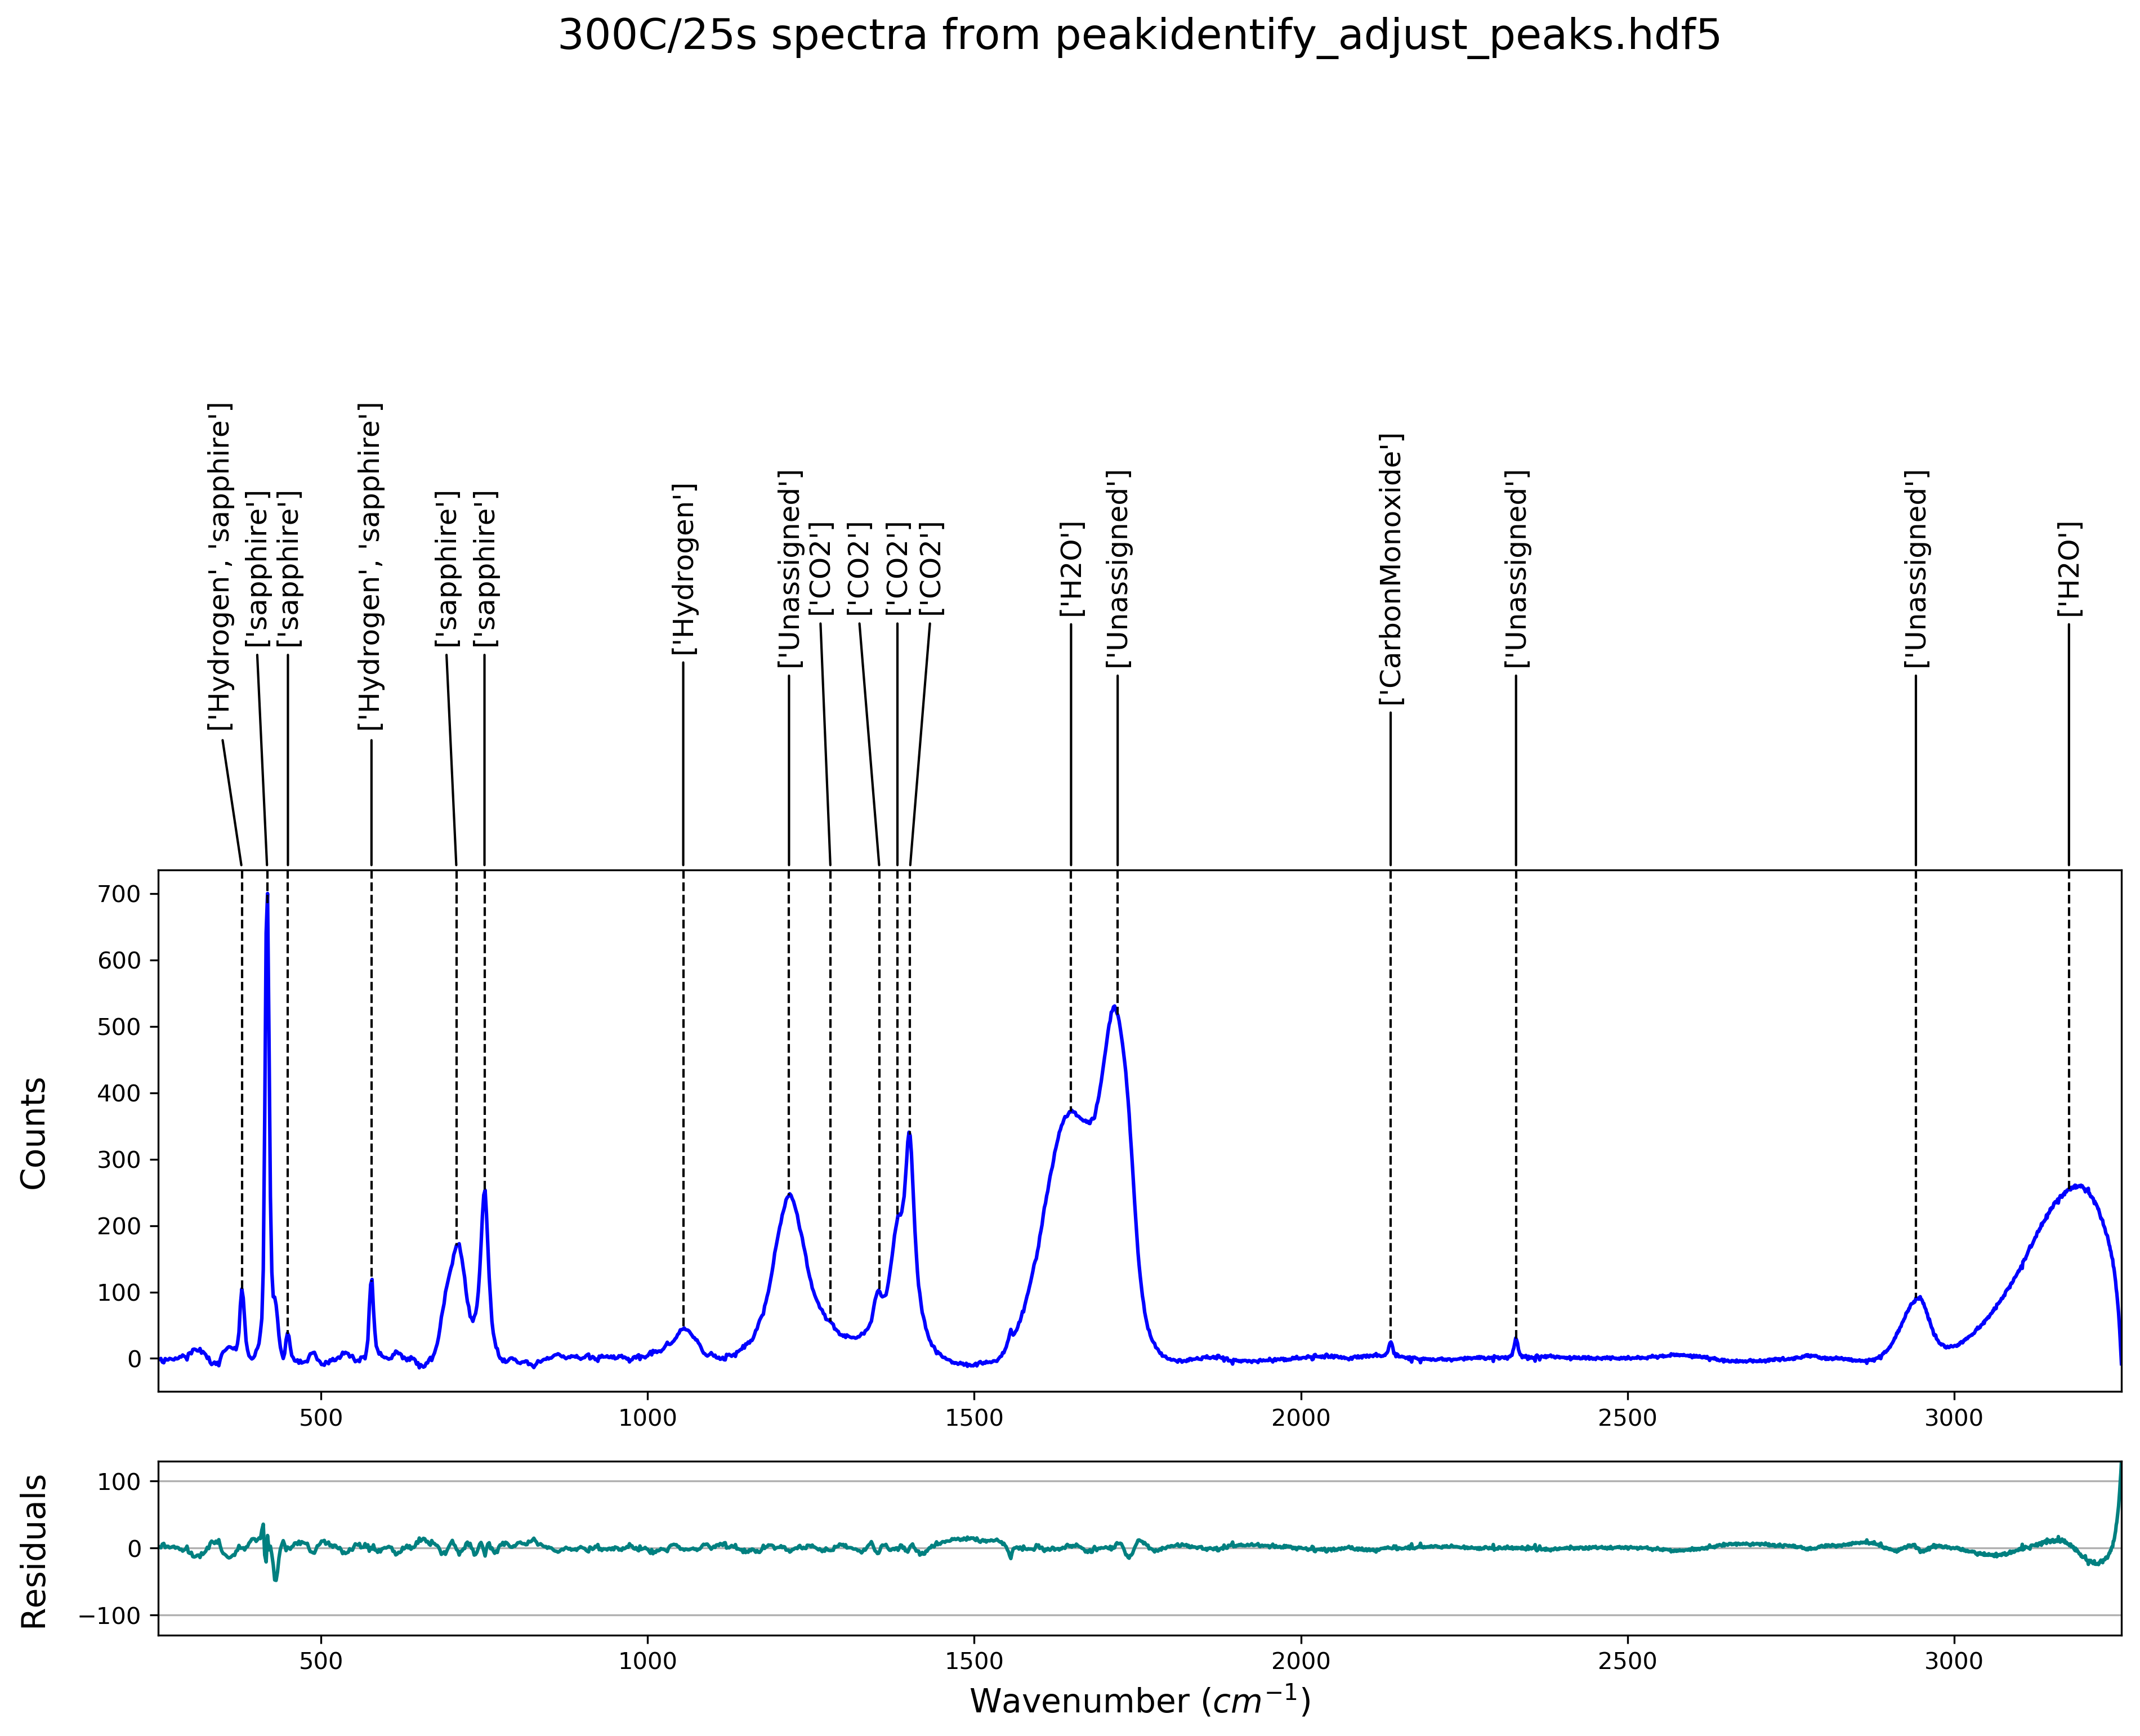

{'CO2': 200.0, 'CarbonMonoxide': 100.0, 'H2O': 100.0, 'Hydrogen': 75.0, 'sapphire': 150.0}


In [81]:
hdf5_calfilename = 'peakidentify_calibration_file.hdf5' #update to hdf5_calfilename
hdf5_expfilename = 'peakidentify_adjust_peaks.hdf5'
temp = 300
time = 25
unknown_x, unknown_y, unknown_peaks, unknown_peak_assignments, percentages, df = peakidentify.peak_assignment(hdf5_expfilename, temp, time, hdf5_calfilename, 50)

In [82]:
dataprep.view_hdf5('peakidentify_adjust_peaks.hdf5')

**** peakidentify_adjust_peaks.hdf5 ****
300C
|    25s
|    |    Peak_01
|    |    Peak_02
|    |    Peak_03
|    |    Peak_04
|    |    Peak_05
|    |    Peak_06
|    |    Peak_07
|    |    Peak_08
|    |    Peak_09*
|    |    Peak_10*
|    |    Peak_11*
|    |    Peak_12
|    |    Peak_13
|    |    Peak_14
|    |    Peak_15
|    |    Peak_16
|    |    Peak_17
|    |    Peak_18
|    |    counts
|    |    residuals
|    |    wavenumber


**** peakidentify_adjust_peaks.hdf5 ****
300C
|    25s
|    |    Peak_01
|    |    Peak_02
|    |    Peak_03
|    |    Peak_04
|    |    Peak_05
|    |    Peak_06
|    |    Peak_07
|    |    Peak_08
|    |    Peak_09*
|    |    Peak_10*
|    |    Peak_11*
|    |    Peak_12
|    |    Peak_13
|    |    Peak_14
|    |    Peak_15
|    |    Peak_16
|    |    Peak_17
|    |    Peak_18
|    |    counts
|    |    residuals
|    |    wavenumber


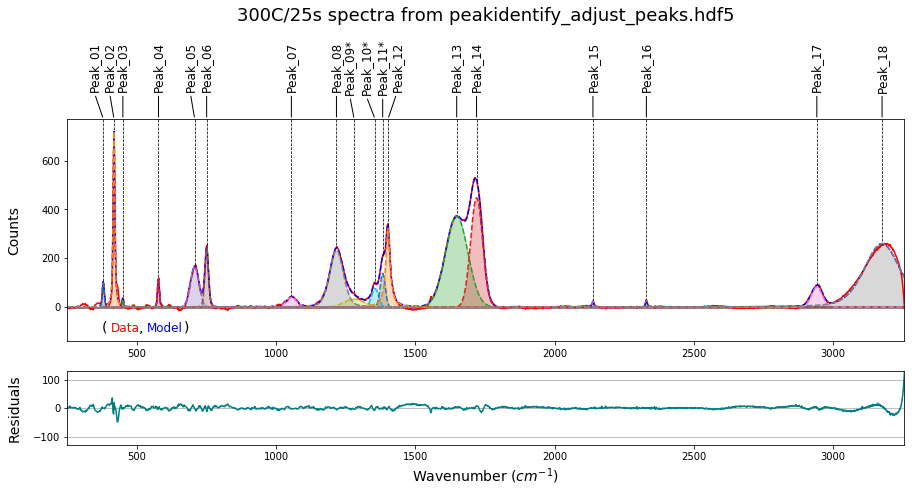

In [83]:
dataprep.view_hdf5('peakidentify_adjust_peaks.hdf5')
fig, ax1, ax2 = datavis.plot_fit(hdf5_filename, key)
datavis.plot_components(ax1, hdf5_filename, key, [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])

## Example 6 Score Sort for 1D Wavenumber
This is a metric of confidence. This score function should be considered as a first visual grading that your peaks are close enough to determine matching. We will provide a simplistic 1D Euclidean distance calculation. 

The reciprocal of the distance is returned as a percentage of distance comparison in the x dimension with 1 equalling peak centers that are super close and 0 super far away respectively. A tuple of the two peak locations compared is returned for visual confirmation of the score.

This scoring function also includes the user input for the choice of normalizing the peak distance scores and sorting them based on the  kth highest score in the peak set. This normalization is performed to bring a better understanding to the peak distance confidence score, and it also allows for future work to be done in determining the best kth highest score normalization to be used. The default k for `peak_1d_score` is zero and is simlpy an integer.

In [84]:
peakidentify.peak_1d_score(unknown_peakstest,H_peaks,scoremax =1, precision = 50)

([0.023877511948914062,
  0.04156346874814082,
  0.09781564639105347,
  0.04706939980154498],
 [(314.77, 355.6504104104104),
  (378.71, 355.6504104104104),
  (578.11, 587.3333133133133),
  (1055.9, 1035.6547747747748)])

The `score_max` function calls upon the `peak_1D_score` to get the highest score = 1 and then will normalize the rest of the score data respectively. Here, the user can input different k values for the # k highest score to be normalized over.

In [85]:
scoremaxk1=peakidentify.score_max(unknown_peakstest,H_peaks,k=1, precision = 50)

The `score_sort` function just appends the score max normalized scores and peak tuples to a list. There is no additional sorting feature added since the score max function already sorts the scores from the lowest to highest peak tuples compared.

In [86]:
data=peakidentify.score_sort(unknown_peakstest,H_peaks,k=1, precision = 50)
print(data)

[([0.2441072857961298, 0.42491636340034805, 1.0, 0.48120522164079976], [(314.77, 355.6504104104104), (378.71, 355.6504104104104), (578.11, 587.3333133133133), (1055.9, 1035.6547747747748)])]


The user should spend some time evaluating how to visually grade their peak distance closeness. It might make sense in some cases to not have a normalized highest peak score. This last example showcases how different k values interact with the score grading. The final k value will output the original not normalized score.

In [87]:
def process_score(unknown_peaks,known_peaks,k, precision, unknownname, knownname):
    if k<len(known_peaks)+1:
        compdf=pd.DataFrame(data=peakidentify.score_sort(unknown_peaks,known_peaks,k, precision)[0][0][:],columns=[str(unknownname)+'_vs_'+str(knownname)+'_peak_Scores normalized over the #'+str(k) + ' highest score in the peak set'])
        compdf=compdf.assign(Peaks=peakidentify.score_sort(unknown_peaks,known_peaks,1, precision)[0][1][:])
    else:
        compdf=pd.DataFrame(data=peakidentify.score_sort(unknown_peaks,known_peaks,k, precision)[0][0][:],columns=[str(unknownname)+'_vs_'+str(knownname)+'_peak_Scores Unnormalized'])
        compdf=compdf.assign(Peaks=peakidentify.score_sort(unknown_peaks,known_peaks,1, precision)[0][1][:])
    return compdf
def score_table(unknown_peaks,known_peaks, precision,unknownname,knownname):
    k_range = range(1,len(known_peaks)+2)
    frames = [ process_score(unknown_peaks,known_peaks,k, precision,unknownname,knownname) for k in k_range ]
    result = pd.concat(frames,axis=1, join='outer', join_axes=None, ignore_index=False,
              keys=None, levels=None, names=None, verify_integrity=False,
              copy=True,sort=True)
    return result

In [88]:
precision = 50
result1 = score_table(unknown_peakstest,H2O_peaks, precision, 'Formic3.6wt%', 'H2O')
result2 = score_table(unknown_peakstest,co_peaks, precision, 'Formic3.6wt%', 'CO')
result3 = score_table(unknown_peakstest,CO2_peaks, precision, 'Formic3.6wt%', 'CO2')
result4 = score_table(unknown_peakstest,sapphire_peaks, precision, 'Formic3.6wt%', 'sapphire')
result5 = score_table(unknown_peakstest,H_peaks, precision, 'Formic3.6wt%', 'H')
result5

Function did not receive a scoremax variable. The variable
        scoremax has been reset back to 1. This is equivalent to 
        your unnormalized score.
Function did not receive a scoremax variable. The variable
        scoremax has been reset back to 1. This is equivalent to 
        your unnormalized score.
Function did not receive a scoremax variable. The variable
        scoremax has been reset back to 1. This is equivalent to 
        your unnormalized score.
Function did not receive a scoremax variable. The variable
        scoremax has been reset back to 1. This is equivalent to 
        your unnormalized score.
Function did not receive a scoremax variable. The variable
        scoremax has been reset back to 1. This is equivalent to 
        your unnormalized score.


,Formic3.6wt%_vs_H_peak_Scores normalized over the #1 highest score in the peak set,Peaks,Formic3.6wt%_vs_H_peak_Scores normalized over the #2 highest score in the peak set,Peaks,Formic3.6wt%_vs_H_peak_Scores normalized over the #3 highest score in the peak set,Peaks,Formic3.6wt%_vs_H_peak_Scores normalized over the #4 highest score in the peak set,Peaks,Formic3.6wt%_vs_H_peak_Scores Unnormalized,Peaks
0,0.244107,"(314.77, 355.6504104104104)",0.507283,"(314.77, 355.6504104104104)",0.574483,"(314.77, 355.6504104104104)",1.000000,"(314.77, 355.6504104104104)",0.023878,"(314.77, 355.6504104104104)"
1,0.424916,"(378.71, 355.6504104104104)",0.883025,"(378.71, 355.6504104104104)",1.000000,"(378.71, 355.6504104104104)",1.740695,"(378.71, 355.6504104104104)",0.041563,"(378.71, 355.6504104104104)"
2,1.000000,"(578.11, 587.3333133133133)",2.078115,"(578.11, 587.3333133133133)",2.353404,"(578.11, 587.3333133133133)",4.096559,"(578.11, 587.3333133133133)",0.097816,"(578.11, 587.3333133133133)"
3,0.481205,"(1055.9, 1035.6547747747748)",1.000000,"(1055.9, 1035.6547747747748)",1.132470,"(1055.9, 1035.6547747747748)",1.971286,"(1055.9, 1035.6547747747748)",0.047069,"(1055.9, 1035.6547747747748)"


In [89]:
frames = [result1,result2,result3,result4,result5]
results = pd.concat(frames,axis=1, join='outer', join_axes=None, ignore_index=True,
              keys=None, levels=None, names=None, verify_integrity=False,
              copy=True,sort=False)
results = results.T
results

,0,1,2,3,4,5,6,7
0,1,0.941748,NaN,NaN,NaN,NaN,NaN,NaN
1,"(1649.3, 1640.6)","(3185.1, 3194.4)",NaN,NaN,NaN,NaN,NaN,NaN
2,1.06186,1,NaN,NaN,NaN,NaN,NaN,NaN
3,"(1649.3, 1640.6)","(3185.1, 3194.4)",NaN,NaN,NaN,NaN,NaN,NaN
4,0.103093,0.0970874,NaN,NaN,NaN,NaN,NaN,NaN
5,"(1649.3, 1640.6)","(3185.1, 3194.4)",NaN,NaN,NaN,NaN,NaN,NaN
6,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,"(2137.9, 2139.9096496496495)",NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.332265,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,"(2137.9, 2139.9096496496495)",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
dataprep.view_hdf5('peakidentify_experiment_file.hdf5')

**** peakidentify_experiment_file.hdf5 ****
300C
|    25s
|    |    Peak_01
|    |    Peak_02
|    |    Peak_03
|    |    Peak_04
|    |    Peak_05
|    |    Peak_06
|    |    Peak_07
|    |    Peak_08
|    |    Peak_09
|    |    Peak_10
|    |    Peak_11
|    |    Peak_12
|    |    Peak_13
|    |    Peak_14
|    |    Peak_15
|    |    Peak_16
|    |    counts
|    |    residuals
|    |    wavenumber


Remove the hdf5 files to keep the system data clean

In [91]:
os.remove('peakidentify_calibration_file.hdf5')
os.remove('peakidentify_experiment_file.hdf5')
os.remove('peakidentify_add_label_test.hdf5')
os.remove('peakidentify_label_test.hdf5')
os.remove('peakidentify_experiment_test.hdf5')
os.remove('peakidentify_experiment_testnoadd.hdf5')
os.remove('peakidentify_adjust_peaks.hdf5')

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'peakidentify_calibration_file.hdf5'